<h2>Step 1: Data Loading and Pre-Processing (Sepsis-3 Cohort)</h2>

<p>
This section handles the ingestion of raw MIMIC-III datasets, applies clinical filtering based on Sepsis-3 definitions, and performs temporal normalization to prepare the data for time-series analysis.
</p>

<h3>1. Data Ingestion &amp; Integrity Check</h3>

<p>
The script first maps and verifies the existence of essential MIMIC-III tables before loading them into Pandas DataFrames:
</p>

<ul>
  <li>
    <b>Clinical Events:</b>
    chartevents (vitals/signs), labevents (laboratory results), and inputevents (fluids/medications).
  </li>
  <li>
    <b>Metadata:</b>
    icustays and admissions for tracking patient stays and demographic links.
  </li>
  <li>
    <b>Sepsis-3 Gold Standard:</b>
    A pre-filtered list of <i>icustay_ids</i> meeting the Sepsis-3 clinical criteria (suspected infection).
  </li>
</ul>

<h3>2. Cohort Selection Criteria</h3>

<p>
To ensure high-quality data and clinical relevance, the following filters are applied:
</p>

<ul>
  <li>
    <b>Length of Stay (LoS):</b>
    Only patients with an ICU stay of at least 24 hours are included.
  </li>
  <li>
    <b>Sepsis-3 Inclusion:</b>
    The dataset is restricted to patients identified in the
    <i>sepsis3_infection_ids</i> reference file.
  </li>
</ul>

<h3>3. Temporal Normalization (Hourly Binning)</h3>

<p>
Medical events in MIMIC-III are recorded at irregular intervals. To transform this into a structured time-series format, we compute a relative time index
(<i>t<sub>bin</sub></i>) for every event.
</p>

<p>
<b>Logic:</b> The admission time (<i>intime</i>) is treated as
<i>t = 0</i>. Every event timestamp is converted into an integer hour representing the elapsed time since admission:
</p>


$$
t_{bin} = \left\lfloor \frac{t_{event} - t_{admission}}{3600\ \text{seconds}} \right\rfloor
$$


<ul>
  <li>
    <b>Pre-admission filtering:</b>
    Any records occurring before the official ICU admission
    (<i>t<sub>bin</sub> &lt; 0</i>) are excluded to maintain a consistent baseline.
  </li>
  <li>
    <b>Granularity:</b>
    This process aligns disparate data points (e.g., a lab result at 02:15 and a heart rate at 02:45) into the same hourly window (Hour 2).
  </li>
</ul>

<h3>Data Summary</h3>

<p>
Upon execution, the script outputs:
</p>

<ul>
  <li>
    <b>Shape Audit:</b>
    The dimensions of all DataFrames to confirm successful filtering.
  </li>
  <li>
    <b>Unique ICU-Time Bins:</b>
    The total number of "Patient-Hour" observation units available in the
    <i>chartevents</i> table, which defines the scale of the feature matrix.
  </li>
</ul>

<p>
<b>Technical Note:</b>
Memory management is optimized using <i>low_memory=False</i> and explicit date parsing.
Given the size of <i>chartevents</i>, ensure your environment has sufficient RAM
(<b>16GB+ recommended</b> for full MIMIC datasets).
</p>


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set global plotting parameters
plt.rcParams['figure.figsize'] = (10, 4)

# Define file mapping for MIMIC-III data
DATA_FILES = {
    'chartevents': 'chartevents.csv',
    'labevents': 'labevents.csv',
    'inputevents': 'inputevents.csv',
    'icustays': 'icustays.csv',
    'admissions': 'admissions.csv',
    'sepsis3_infection_ids': 'sepsis3_infection_ids.csv'
}

# Check for existence of data files
for key, filename in DATA_FILES.items():
    status = 'FOUND' if os.path.exists(filename) else 'MISSING'
    print(f"{filename} -> {status}")

def load():
    """
    Loads required MIMIC-III CSV files into pandas DataFrames.
    Returns: Tuple of DataFrames (chartevents, labevents, inputevents, icustays, admissions)
    """
    present = all(os.path.exists(f) for f in DATA_FILES.values())

    if present:
        print('Loading CSVs (this may take a while for full MIMIC datasets)...')

        chartevents = pd.read_csv(DATA_FILES['chartevents'], parse_dates=['charttime'], low_memory=False)
        labevents = pd.read_csv(DATA_FILES['labevents'], parse_dates=['charttime'], low_memory=False)
        inputevents = pd.read_csv(DATA_FILES['inputevents'], parse_dates=['starttime', 'endtime'], low_memory=False)
        icustays = pd.read_csv(DATA_FILES['icustays'], parse_dates=['intime', 'outtime'], low_memory=False)
        admissions = pd.read_csv(DATA_FILES['admissions'], parse_dates=['admittime', 'dischtime', 'deathtime'], low_memory=False)

        return chartevents, labevents, inputevents, icustays, admissions
    else:
        raise FileNotFoundError('Data files are missing. Please ensure all required CSV files are in the directory.')

# Initialize DataFrames
chartevents, labevents, inputevents, icustays, admissions = load()

# Eğer 'intime' ve 'outtime' sütunlarınız varsa:
icustays = icustays[(icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600 >= 24]

# Load valid Sepsis-3 patient IDs (previously filtered via SQL)
sepsis3_ids_df = pd.read_csv(DATA_FILES['sepsis3_infection_ids'],  low_memory=False)
sepsis3_infection_ids = sepsis3_ids_df['icustay_id'].unique()

# Filter icustays DataFrame to include only Sepsis-3 cohorts
icustays = icustays[icustays['icustay_id'].isin(sepsis3_infection_ids)]

print('Loaded shapes:', chartevents.shape, labevents.shape, inputevents.shape, icustays.shape, admissions.shape)

def compute_hour_bin(df, time_col, icustay_df):
    """
    Computes hourly bins for events relative to the ICU admission time (intime).

    Args:
        df: The DataFrame containing event data.
        time_col: The name of the column containing the timestamp.
        icustay_df: The icustays DataFrame containing admission times.
    """
    df = df.copy()

    if 'icustay_id' not in df.columns:
        raise ValueError('icustay_id is required in the source dataframe')

    # Extract admission times and merge with event data
    icu_intime = icustay_df[['icustay_id', 'intime']].drop_duplicates()
    df = df.merge(icu_intime, on='icustay_id', how='inner')

    # Calculate the hour bin (t_bin) relative to admission
    # (Event time - Admission time) converted to hours
    df['t_bin'] = ((df[time_col] - df['intime']).dt.total_seconds() // 3600 ).astype(int)

    # Keep only records that occurred during or after admission
    df = df[df['t_bin'] >= 0]

    return df

# Apply hourly binning to events
chartevents = compute_hour_bin(chartevents, 'charttime', icustays)
labevents = compute_hour_bin(labevents, 'charttime', icustays)
inputevents = compute_hour_bin(inputevents, 'starttime', icustays)

# Summary of processed data
unique_bins = chartevents[['icustay_id', 't_bin']].drop_duplicates().shape[0]
print(f'After binning: {unique_bins} unique ICU-time bins found in chartevents')


chartevents.csv -> FOUND
labevents.csv -> FOUND
inputevents.csv -> FOUND
icustays.csv -> FOUND
admissions.csv -> FOUND
sepsis3_infection_ids.csv -> FOUND
Loading CSVs (this may take a while for full MIMIC datasets)...
Loaded shapes: (13064582, 6) (2000653, 6) (663006, 7) (14396, 8) (58976, 19)
After binning: 1600240 unique ICU-time bins found in chartevents


<div style="padding: 20px; border-left: 6px solid #2e7d32; border-radius: 4px;">
    <h2 style="margin-top: 0;">Step 2: Clinical Data Preprocessing & Feature Engineering</h2>
    <p>This section performs critical data cleaning, integration, and multivariate imputation for <b>MIMIC-IV</b> vitals and lab results.</p>
    <h3 >Key Operations:</h3>
    <ul style="line-height: 1.6;">
        <li><b>Feature Integration:</b> Merges redundant clinical IDs (e.g., Invasive/Non-invasive MAP, various FiO2 sources, and GCS components).</li>
        <li><b>Physiological Filtering:</b> Applies <code>MASTER_BOUNDS</code> to remove measurement errors (outliers) based on clinical literature.</li>
        <li><b>Units Normalization:</b> Automatically converts FiO2 percentages (0-100) to decimal format (0.21-1.0).</li>
        <li><b>Advanced Imputation:</b> 
            <ul>
                <li><i>Longitudinal:</i> Forward and backward filling within specific ICU stays.</li>
                <li><i>Multivariate:</i> Uses <b>IterativeImputer</b> (MICE) constrained by clinical boundaries to estimate missing values based on feature correlations.</li>
            </ul>
        </li>
    </ul>
    <div style="padding: 10px; border-radius: 5px; border: 1px solid;">
        <strong>Note:</strong> All imputation outputs are strictly bounded to maintain physiological validity (e.g., GCS is forced between 3 and 15).
    </div>
</div>

In [18]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. IDENTIFICATION OF ITEM IDs
# Vital Signs
map_id, apmean, hr_id, rr_id, spo2_id, gcs_id = 220052, 220181, 220045, 220210, 220277, 226755
pao2_id, fio2_id, fio2_alt1, fio2_alt2 = 220224, 223835, 226754, 227033
gcs_eye_id, gcs_verbal_id, gcs_motor_id = 220739, 223900, 223901

# Laboratory Values
platelets_id, bilirubin_id, creatinine_id, lactate_id = 51265, 50885, 50912, 50813

# 2. MASTER CLINICAL BOUNDARIES
# Single source of truth for both outlier removal and constrained imputation
MASTER_BOUNDS = {
    hr_id: (20, 250),          # Heart Rate (bpm)
    map_id: (20, 250),         # Mean Arterial Pressure (mmHg)
    rr_id: (0, 80),            # Respiratory Rate (breaths/min)
    spo2_id: (50, 100),        # Oxygen Saturation (%)
    gcs_id: (3, 15),           # Glasgow Coma Scale (Total)
    pao2_id: (20, 700),        # PaO2 (mmHg)
    fio2_id: (0.21, 1.0),      # FiO2 (Decimal format)
    lactate_id: (0.1, 30.0),   # Lactate (mmol/L)
    creatinine_id: (0.1, 30.0),# Creatinine (mg/dL)
    bilirubin_id: (0.1, 80.0), # Bilirubin (mg/dL)
    platelets_id: (1, 2000)    # Platelets (k/uL)
}

vitals_list = [map_id, apmean, hr_id, rr_id, spo2_id, gcs_id, pao2_id, fio2_id, fio2_alt1, fio2_alt2, gcs_eye_id, gcs_verbal_id, gcs_motor_id]
labs_list = [platelets_id, bilirubin_id, creatinine_id, lactate_id]

### DATA PIVOTING ###
# Transform long format to wide format (Columns: itemids, Rows: stay_id + time_bin)
vitals = chartevents[chartevents['itemid'].isin(vitals_list)][['icustay_id','t_bin','itemid','valuenum']]
vitals_pivot = vitals.groupby(['icustay_id', 't_bin', 'itemid'])['valuenum'].median().unstack(level=-1) if not vitals.empty else pd.DataFrame()

labs = labevents[labevents['itemid'].isin(labs_list)][['icustay_id','t_bin','itemid','valuenum']]
labs_pivot = labs.groupby(['icustay_id', 't_bin', 'itemid'])['valuenum'].median().unstack(level=-1) if not labs.empty else pd.DataFrame()

state_df = vitals_pivot.join(labs_pivot, how='outer').sort_index()

### DATA INTEGRATION & MERGING ###

# MAP Integration: Merge Non-Invasive into Invasive MAP column
if apmean in state_df.columns:
    if map_id in state_df.columns:
        state_df[map_id] = state_df[map_id].fillna(state_df[apmean])
    else:
        state_df[map_id] = state_df[apmean]
    state_df.drop(columns=[apmean], inplace=True, errors='ignore')

# FiO2 Integration & Normalization: Combine multiple IDs and ensure decimal format
if fio2_id not in state_df.columns: 
    state_df[fio2_id] = np.nan

for alt_id in [fio2_alt1, fio2_alt2]:
    if alt_id in state_df.columns:
        # Normalize percentages (e.g., 100) to decimals (1.0)
        state_df.loc[state_df[alt_id] > 1.0, alt_id] /= 100.0
        state_df[fio2_id] = state_df[fio2_id].fillna(state_df[alt_id])
        state_df.drop(columns=[alt_id], inplace=True)

# Final check for main FiO2 column normalization
state_df.loc[state_df[fio2_id] > 1.0, fio2_id] /= 100.0

# GCS Integration: Calculate total GCS from components if total is missing
if gcs_id not in state_df.columns: 
    state_df[gcs_id] = np.nan

gcs_components = [gcs_eye_id, gcs_verbal_id, gcs_motor_id]
existing_gcs_cols = [c for c in gcs_components if c in state_df.columns]

if existing_gcs_cols:
    gcs_sum = state_df[existing_gcs_cols].sum(axis=1, min_count=1)
    state_df[gcs_id] = state_df[gcs_id].fillna(gcs_sum)
    state_df.drop(columns=existing_gcs_cols, inplace=True)

### OUTLIER FILTERING (Cleaning Phase) ###
# Remove values that are physiologically impossible based on MASTER_BOUNDS
print("Applying physiological filters...")
cleaned_count = 0
for col_id, (min_v, max_v) in MASTER_BOUNDS.items():
    if col_id in state_df.columns:
        mask = (state_df[col_id] < min_v) | (state_df[col_id] > max_v)
        cleaned_count += mask.sum()
        state_df.loc[mask, col_id] = np.nan
print(f"Total outlier points removed: {cleaned_count}")

### IMPUTATION (Filling Missing Values) ###

# 1. Longitudinal Imputation: Carry values forward/backward within the same ICU stay
state_df = state_df.groupby(level=0, group_keys=False).apply(lambda df: df.ffill().bfill())

# 2. Multivariate Imputation: Estimate remaining NaNs using correlations between features
# Ensure we only impute columns that exist and have at least some data
cols_to_impute = [c for c in MASTER_BOUNDS.keys() if c in state_df.columns and state_df[c].notna().any()]

if cols_to_impute:
    # Extract bounds for the imputer to keep generated values within clinical ranges
    min_vals = [MASTER_BOUNDS[c][0] for c in cols_to_impute]
    max_vals = [MASTER_BOUNDS[c][1] for c in cols_to_impute]
    
    imputer = IterativeImputer(
        max_iter=10, 
        random_state=42, 
        min_value=min_vals, 
        max_value=max_vals
    )
    
    # Apply imputation
    state_df[cols_to_impute] = imputer.fit_transform(state_df[cols_to_impute])
    print(f"✅ Imputation complete for {len(cols_to_impute)} features.")

# 3. Final Fallback: Fill any remaining NaNs (where no data existed for a stay) with 0
state_df = state_df.fillna(0)

print('Final state_df shape:', state_df.shape)


Applying physiological filters...
Total outlier points removed: 5678
✅ Imputation complete for 11 features.
Final state_df shape: (1605593, 11)


<div style="padding: 20px; background-color: ; border-left: 6px solid ; border-radius: 4px;">
    <h2 style="color:  margin-top: 0;">Step 3: Outcome Integration (Mortality Labeling)</h2>
    <p>In this phase, we map the <b>Ground Truth</b> labels to our feature-engineered state matrix. This transforms the longitudinal ICU data into a labeled dataset suitable for supervised machine learning.</p>
    <h3 >Process Workflow:</h3>
    <ul style="line-height: 1.6;">
        <li><b>Source Mapping:</b> Extracts the <code>hospital_expire_flag</code> from the <i>Admissions</i> table, serving as the primary binary outcome.</li>
        <li><b>Relational Join:</b> Bridges <i>Admissions</i> and <i>ICU Stays</i> using <code>hadm_id</code> to ensure each time bin is correctly associated with the patient's eventual outcome.</li>
        <li><b>Index Preservation:</b> Re-establishes the Multi-Index structure <code>(icustay_id, t_bin)</code> to maintain the temporal integrity of the time-series data.</li>
        <li><b>Class Balance Audit:</b> Performs a patient-level count of survivors vs. deceased to assess dataset imbalance.</li>
    </ul>
    <div style="padding: 10px; border-radius: 5px; border: 1px solid ">
        <strong>Clinical Relevance:</strong> The <code>hospital_expire_flag</code> indicates whether the patient died during the hospital stay. In RL or predictive modeling, this label typically serves as the terminal signal for reward calculation or classification targets.
    </div>
</div>

In [19]:
import pandas as pd

# =========================================================
# 5. INTEGRATE MORTALITY LABELS (Outcome Data)
# =========================================================

# Extract hospital mortality flags from the admissions table
# hospital_expire_flag: 1 = Deceased, 0 = Survived
mortality_data = admissions[['hadm_id', 'hospital_expire_flag']]

# Map mortality data to ICU stays via the Hospital Admission ID (hadm_id)
icu_mortality = icustays[['icustay_id', 'hadm_id']].merge(mortality_data, on='hadm_id', how='left')

# Keep only the essential columns for merging with the state matrix
icu_mortality = icu_mortality[['icustay_id', 'hospital_expire_flag']]

# Merge mortality labels into the main state DataFrame
# We reset the index temporarily to perform the merge on 'icustay_id'
state_df = state_df.reset_index().merge(icu_mortality, on='icustay_id', how='left')

# Restore the multi-index (Stay ID and Time Bin) and ensure chronological order
state_df = state_df.set_index(['icustay_id', 't_bin']).sort_index()

print("Mortality labels successfully integrated.")
print("Updated columns:", state_df.columns.tolist())

# Display distribution of outcomes (Class balance check)
print("\nOutcome Distribution (hospital_expire_flag):")
print(state_df.groupby(level=0)['hospital_expire_flag'].first().value_counts())


Mortality labels successfully integrated.
Updated columns: [220045, 220052, 220210, 220224, 220277, 223835, 50813, 50885, 50912, 51265, 226755, 'hospital_expire_flag']

Outcome Distribution (hospital_expire_flag):
hospital_expire_flag
0    12520
1     1873
Name: count, dtype: int64


<div style="padding: 20px;  border-left: 6px solid; border-radius: 4px;">
    <h2 style="margin-top: 0;">Step 4: Action Space Discretization (A)</h2>
    <p>This section defines the <b>Action Space</b> for the Reinforcement Learning agent by transforming continuous medical interventions into discrete, searchable categories.</p>
    <h3 >Discretization Logic:</h3>
    <ul style="line-height: 1.6;">
        <li><b>IV Fluid Resuscitation:</b> Aggregated by sum (ml) and divided into 5 dosage bins (None to High).</li>
        <li><b>Vasopressor Therapy:</b> Aggregated by peak rate (mcg/kg/min) and divided into 5 dosage bins (None to Very High).</li>
        <li><b>Composite Action Matrix:</b> A 5x5 grid creating <b>25 unique treatment combinations</b>. This mapping allows the model to treat fluids and vasopressors as a joint therapeutic decision.</li>
    </ul>
    <h3 style=>Implementation Details:</h3>
    <ul style="line-height: 1.6;">
        <li><b>Time-Series Alignment:</b> Synchronizes treatment events with the state bins. Periods with no recorded intervention are explicitly labeled as <code>Action 0</code> (No Treatment).</li>
        <li><b>Safe Join:</b> Integrates discretized actions into the <code>state_df</code> while maintaining the temporal integrity of each ICU stay.</li>
    </ul>
    <div style="padding: 10px; border-radius: 5px; border: 1px solid ">
        <strong>RL Context:</strong> Discretizing actions is a standard approach in medical RL (e.g., "The AI Clinician") to handle the high variance of dosing in clinical practice and to facilitate policy evaluation.
    </div>
</div>

In [20]:
import numpy as np
import pandas as pd

print("Initializing Action Space definition (using SQL data)...")

inputevents['normalized_amount_ml'] = inputevents['normalized_amount_ml'].fillna(0)
inputevents['normalized_rate_mcgkgmin'] = inputevents['normalized_rate_mcgkgmin'].fillna(0)
actions = inputevents.groupby(['icustay_id', 't_bin']).agg({
    'normalized_amount_ml': 'sum',
    'normalized_rate_mcgkgmin': 'max'
})
actions = actions.rename(columns={
    'normalized_amount_ml': 'total_fluid',
    'normalized_rate_mcgkgmin': 'max_vaso'
})
# Discretization - Binning
# Converting continuous values into 5 discrete categories (0-4) for the RL model.

# --- FLUIDS (ml/hour) ---
# Intervals: 0 (None), 1-50 (Very Low), 50-200 (Low), 200-500 (Medium), >500 (High)
actions['fluid_discrete'] = pd.cut(
    actions['total_fluid'], 
    bins=[-1, 1, 50, 200, 500, np.inf], 
    labels=[0, 1, 2, 3, 4]
)
# Convert categorical data to integer codes 
actions['fluid_discrete'] = actions['fluid_discrete'].cat.codes
actions['fluid_discrete'] = actions['fluid_discrete'].replace(-1, 0).astype(int)

# --- VASOPRESSORS (mcg/kg/min) ---
# Intervals: 0 (None), <0.08 (Low), 0.08-0.22 (Medium), 0.22-0.45 (High), >0.45 (Very High)
actions['vaso_discrete'] = pd.cut(
    actions['max_vaso'], 
    bins=[-1, 0.0001, 0.08, 0.22, 0.45, np.inf], 
    labels=[0, 1, 2, 3, 4]
)
actions['vaso_discrete'] = actions['vaso_discrete'].cat.codes
actions['vaso_discrete'] = actions['vaso_discrete'].replace(-1, 0).astype(int)

# Composite Action Creation
# 5 fluid levels x 5 vasopressor levels = 25 distinct actions (mapped 0-24)
# Formula: (Fluid_Level * 5) + Vasopressor_Level
actions['action'] = (actions['fluid_discrete'] * 5) + actions['vaso_discrete']

# Time-Series Alignment
# Inputevents only records when drugs were given. Missing hours must be filled.
actions = actions.groupby(level=0, group_keys=False).apply(lambda df: df.ffill().bfill())

# Safe Merge into Main State DataFrame
# Merging the actions table with state_df. 
cols_to_join = ['action', 'total_fluid', 'max_vaso']

# Drop existing columns if the cell is re-run to prevent duplication errors
state_df = state_df.drop(columns=[c for c in cols_to_join if c in state_df.columns], errors='ignore')

# Perform Left Join to maintain the longitudinal structure of state_df
state_df = state_df.join(actions[cols_to_join], how='left')

# Fill missing time bins with 0 (Action 0: No treatment given)
state_df['action'] = state_df['action'].fillna(0).astype(int)
state_df['total_fluid'] = state_df['total_fluid'].fillna(0)
state_df['max_vaso'] = state_df['max_vaso'].fillna(0)

# Results Validation
print("Action Space definition complete.")
print("-" * 30)
print(f"Total Rows in DataFrame: {len(state_df)}")
print("-" * 30)
print("Action Distribution (Top 10 Actions):")
print(state_df['action'].value_counts().sort_index().head(10))
print("-" * 30)
print("Sample Data (First 5 Rows):")
print(state_df[['total_fluid', 'max_vaso', 'action']].head())


Initializing Action Space definition (using SQL data)...
Action Space definition complete.
------------------------------
Total Rows in DataFrame: 1605593
------------------------------
Action Distribution (Top 10 Actions):
action
0    1297309
1       1609
2        476
3        241
4       3606
5      80875
6      14156
7      10989
8       6443
9      20698
Name: count, dtype: int64
------------------------------
Sample Data (First 5 Rows):
                  total_fluid  max_vaso  action
icustay_id t_bin                               
200001.0   0         0.000000       0.0       0
           1         0.000000       0.0       0
           2         0.000000       0.0       0
           3         0.000000       0.0       0
           4       200.000006       0.0      15


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">
    <h2 style="margin-top: 0;">Step 5: SOFA Score Calculation</h2>
    <p>The <b>Sequential Organ Failure Assessment (SOFA)</b> score is a gold-standard clinical metric used to track a patient's status and organ dysfunction during an ICU stay.</p>
    <h3>Organ System Components:</h3>
    <ul style="line-height: 1.6;">
        <li><b>Respiration:</b> Based on the PaO_2/FiO_2 ratio.</li>
        <li><b>Coagulation:</b> Evaluated using Platelet counts.</li>
        <li><b>Liver Function:</b> Determined by Bilirubin levels.</li>
        <li><b>Cardiovascular:</b> Based on Mean Arterial Pressure (MAP) and Vasopressor dosage.</li>
        <li><b>Central Nervous System:</b> Calculated using the Glasgow Coma Scale (GCS).</li>
        <li><b>Renal Function:</b> Measured by Creatinine levels.</li>
    </ul>
    <div style="padding: 10px; border-radius: 5px; border: 1px solid;">
        <strong>Research Value:</strong> Adding the SOFA score to the state vector (S) provides the RL agent with a high-level summary of the patient's illness severity, which is highly predictive of mortality and treatment response.
    </div>
</div>

In [21]:
# 1. Preparation: Reset indices so 'icustay_id' and 't_bin' become columns for processing
if isinstance(state_df.index, pd.MultiIndex):
    state_df = state_df.reset_index()

def sofa_resp(pao2, fio2):
    # If PaO2 or FiO2 is missing, assume normal (Score 0)
    if pd.isna(pao2) or pd.isna(fio2) or fio2 == 0:
        return 0
    
    # In MIMIC datasets, FiO2 can be % (21-100) or decimal (0.21-1.0).
    # Standardize to decimal (0-1). If > 1, normalize by dividing by 100.
    if fio2 > 1.0: fio2 = fio2 / 100.0
        
    ratio = pao2 / fio2
    
    if ratio < 100: return 4
    elif ratio < 200: return 3
    elif ratio < 300: return 2
    elif ratio < 400: return 1
    return 0

def sofa_coag(platelets):
    if pd.isna(platelets): return 0 # Assume normal if data is missing
    if platelets < 20: return 4
    elif platelets < 50: return 3
    elif platelets < 100: return 2
    elif platelets < 150: return 1
    return 0

def sofa_liver(bilirubin):
    if pd.isna(bilirubin): return 0
    if bilirubin >= 12.0: return 4
    elif bilirubin >= 6.0: return 3
    elif bilirubin >= 2.0: return 2
    elif bilirubin >= 1.2: return 1
    return 0

def sofa_cns(gcs):
    # Standard practice is to assume normal GCS (15) if missing
    if pd.isna(gcs): return 0 
    if gcs <= 5: return 4
    elif gcs <= 9: return 3
    elif gcs <= 12: return 2
    elif gcs <= 14: return 1
    return 0

def sofa_renal(creatinine):
    if pd.isna(creatinine): return 0
    if creatinine >= 5.0: return 4
    elif creatinine >= 3.5: return 3
    elif creatinine >= 2.0: return 2
    elif creatinine >= 1.2: return 1
    return 0

def sofa_cardio(map_val, max_vaso_rate):
    """
    Cardiovascular Score (Based on MIMIC Metavision logic):
    Score 0: MAP >= 70 mmHg
    Score 1: MAP < 70 mmHg (without vasopressors)
    Score 2: Dopamine <= 5 or Dobutamine (any dose)
    Score 3: Dopamine > 5 or Epinephrine <= 0.1 or Norepinephrine <= 0.1
    Score 4: Dopamine > 15 or Epinephrine > 0.1 or Norepinephrine > 0.1
    """
    # Note: max_vaso_rate represents Norepinephrine Equivalent or max dose.
    # Simplified CV scoring is common in RL models due to the use of composite actions.
    # The following logic scores based on 'Max Vaso Dose'.
    
    if max_vaso_rate > 0.1: return 4
    elif max_vaso_rate > 0.05: return 3 # Between 0.05 - 0.1
    elif max_vaso_rate > 0: return 2    # Very low dose vasopressor
    elif map_val < 70: return 1         # No meds but low blood pressure
    return 0

# --- MAIN CALCULATION FUNCTION ---

def compute_sofa_row(row):
    # Ensure IDs match the variables defined in your previous preprocessing steps.
    
    # 1. Extract Values (Returns NaN if missing)
    pao2 = row.get(220224, np.nan)
    fio2 = row.get(223835, np.nan)
    platelets = row.get(51265, np.nan)
    bilirubin = row.get(50885, np.nan)
    creatinine = row.get(50912, np.nan)
    gcs = row.get(226755, np.nan)
    map_val = row.get(220052, np.nan)
    
    # Vasopressor rate (column added to state_df from SQL processing)
    # Default to 0.0 if column is missing
    vaso_rate = row['max_vaso'] if 'max_vaso' in row else 0.0
    
    # 2. Calculate Sub-scores
    s_resp = sofa_resp(pao2, fio2)
    s_coag = sofa_coag(platelets)
    s_liver = sofa_liver(bilirubin)
    s_cns = sofa_cns(gcs)
    s_cardio = sofa_cardio(map_val, vaso_rate)
    s_renal = sofa_renal(creatinine)
    
    return s_resp + s_coag + s_liver + s_cns + s_cardio + s_renal

# Apply Calculation
print('Calculating SOFA scores based on SQL-normalized data...')
# Process row by row using axis=1
state_df['sofa'] = state_df.apply(compute_sofa_row, axis=1)

# Restore multi-index structure
state_df = state_df.set_index(['icustay_id', 't_bin']).sort_index()

print('SOFA calculation complete.')
print(state_df['sofa'].describe())
print(state_df[['sofa']].head())


Calculating SOFA scores based on SQL-normalized data...
SOFA calculation complete.
count    1.605593e+06
mean     6.221534e+00
std      3.003069e+00
min      0.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      2.300000e+01
Name: sofa, dtype: float64
                  sofa
icustay_id t_bin      
200001.0   0         5
           1         5
           2         5
           3         5
           4         6


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">
    <h2 style="margin-top: 0;">Step 6: Sepsis-3 Cohort Refinement</h2>
    <p>This critical filtering step ensures that the study population meets the <b>Sepsis-3 Third International Consensus</b> definitions for sepsis.</p>
    <h3 Refinement Logic:</h3>
    <ul style="line-height: 1.6;">
        <li><b>Organ Dysfunction:</b> Defined as an acute change in total SOFA score >= 2 points consequent to the infection.</li>
        <li><b>Baseline Assumption:</b> In accordance with clinical standards, the baseline SOFA score is assumed to be 0 unless a prior chronic dysfunction is known.</li>
        <li><b>Inclusion Criterion:</b> Any patient whose <code>max(SOFA)</code> during their stay is >= 2 is retained in the cohort.</li>
    </ul>
    <div style="padding: 10px; border-radius: 5px; border: 1px solid;">
        <strong>Clinical Justification:</strong> Patients with a SOFA score < 2 have a significantly lower risk of mortality (approx. 0.1%). Focusing on >= 2 ensures the Reinforcement Learning agent learns policies for patients at high clinical risk.
    </div>
</div>

In [22]:
# =========================================================
# 9. SEPSIS-3 COHORT REFINEMENT (Corrected Logic)
# =========================================================

print("Filtering cohort based on Sepsis-3 criteria...")

# Sepsis-3 Definition: Suspected infection + increase in SOFA score >= 2 points.
# NOTE: If the patient's baseline is unknown, it is assumed to be 0. 
# Therefore, any instance of SOFA >= 2 in the ICU is sufficient for patients 
# with suspected infection (which is the basis of this dataset).

# 1. Calculate Max SOFA for each stay using 'transform' for performance
# We perform this directly on the index without needing to reset it
max_sofa_per_stay = state_df['sofa'].groupby('icustay_id').transform('max')

# 2. Criterion: Patients with a Maximum SOFA score of 2 or higher
# This covers both those who deteriorate in the ICU and those who arrive with high scores.
# Previous logic error: Using (max - first) >= 2 would incorrectly exclude patients 
# who arrived in a severe state but remained stable.
valid_mask = max_sofa_per_stay >= 2

# 3. Filtering
original_count = state_df.index.get_level_values('icustay_id').nunique()
state_df = state_df[valid_mask]
final_count = state_df.index.get_level_values('icustay_id').nunique()

print(f"Cohort refinement complete.")
print(f"Original ICU Stays: {original_count}")
print(f"Final Sepsis-3 ICU Stays (SOFA >= 2): {final_count}")
print(f"Dropped Stays: {original_count - final_count}")
print(f"Final state_df record count: {len(state_df)}")

print("-" * 30)
print('--- Action Distribution (First 25 indices) ---')
# Check action distribution (Action 0 is typically the most frequent)
print(state_df['action'].value_counts().sort_index().head(25))


Filtering cohort based on Sepsis-3 criteria...
Cohort refinement complete.
Original ICU Stays: 14393
Final Sepsis-3 ICU Stays (SOFA >= 2): 14383
Dropped Stays: 10
Final state_df record count: 1605219
------------------------------
--- Action Distribution (First 25 indices) ---
action
0     1296969
1        1609
2         476
3         241
4        3606
5       80869
6       14156
7       10989
8        6443
9       20698
10      47784
11       2499
12       5070
13       3352
14      11368
15      48561
16       1417
17       2000
18       1790
19       5937
20      29725
21       1390
22       1728
23       1365
24       5177
Name: count, dtype: int64


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

## Step 7: Reward Engineering & Transition Mapping

This phase finalizes the **MDP Environment** by constructing the transition pairs $(S_t, A_t, R_t, S_{t+1})$ necessary for Reinforcement Learning training.



### The Multi-Objective Reward Function ($R$):

* **Organ Recovery:** Difference in SOFA scores (higher is better).
* **Hemodynamic Stability:** +0.5 for maintaining MAP between 65-100 mmHg.
* **Metabolic Improvement:** +1.0 for successful Lactate clearance.
* **Terminal Survival:** Significant sparse rewards ($\pm 10$) at the end of the trajectory based on hospital outcome.

### Transition Dynamics ($S \to S'$):

We use a `shift(-1)` operation grouped by ICU stay to align the current feature set with the observation from the following time bin, effectively modeling how treatments influence patient physiology.

<div style="padding: 10px; border-radius: 5px; border: 1px solid;">
    <strong>Clinical Intent:</strong> By providing intermediate feedback (Lactate, MAP, SOFA), the agent learns "short-term wins" that correlate with the "long-term goal" of survival.
</div>

</div>

In [23]:
import numpy as np
import pandas as pd

# 1. Sorting and Preparation
state_df = state_df.sort_index(level=['icustay_id', 't_bin'])

# 2. Integrating Mortality Data
if 'hospital_expire_flag' not in state_df.columns:
    if 'hospital_expire_flag' in admissions.columns:
        expire_info = admissions[['hadm_id', 'hospital_expire_flag']].drop_duplicates()
        stay_map = icustays[['icustay_id', 'hadm_id']]
        mortality_map = stay_map.merge(expire_info, on='hadm_id', how='left')[['icustay_id', 'hospital_expire_flag']]
        state_df = state_df.join(mortality_map.set_index('icustay_id'), on='icustay_id')
    else:
        print("WARNING: 'hospital_expire_flag' not found! Terminal rewards may not function correctly.")

# 3. Preparation for Next SOFA and Next Lactate
# Using shift(-1) within groups to look ahead to the next time step
state_df['next_sofa'] = state_df.groupby(level=0)['sofa'].shift(-1)

# Calculate next value for Lactate (Item ID: 50813) if available
if 50813 in state_df.columns:
    state_df['next_lactate'] = state_df.groupby(level=0)[50813].shift(-1)
else:
    state_df['next_lactate'] = np.nan # No impact if data is missing

# 4. Done Flag (Terminal state indicator)
state_df['done'] = state_df['next_sofa'].isna().astype(int)

# Intermediate reward (VECTORIZED CALCULATION)
# ---------------------------------------------------------
# Define variables based on Item IDs (assuming RAW, unscaled data)
cur_map = state_df[220052] if 220052 in state_df.columns else pd.Series(0, index=state_df.index)
cur_lactate = state_df[50813] if 50813 in state_df.columns else pd.Series(0, index=state_df.index)
next_lactate = state_df['next_lactate']

# A) SOFA-based Reward: Positive reward for decreasing SOFA score
reward_sofa = (state_df['sofa'] - state_df['next_sofa'])

# B) Mean Arterial Pressure (MAP) Reward
# Range 65-100 is considered stable (+0.5), below 65 is critical (-0.5)
reward_map = np.where((cur_map >= 65) & (cur_map <= 100), 0.5, 
             np.where(cur_map < 65, -0.5, 0))

# C) Lactate Clearance Reward: +1.0 if lactate decreases in the next step
reward_lactate = np.where(next_lactate < cur_lactate, 1.0, 0)

# D) Combined Intermediate Reward
state_df['reward'] = reward_sofa + reward_map + reward_lactate

# Terminal reward (Survival vs Mortality)
is_terminal = state_df['done'] == 1
is_dead = state_df['hospital_expire_flag'] == 1

# Overwrite terminal rewards at the end of the trajectory
# Using +/-10 for stability; some literature uses +/-10
state_df.loc[is_terminal & is_dead, 'reward'] = -10.0
state_df.loc[is_terminal & ~is_dead, 'reward'] = +10.0

# Clean NaN rewards
state_df['reward'] = state_df['reward'].fillna(0.0)

# State transation mapping (S -> S')

feature_itemids = [
    220052, 220045, 220210, 220277, 226755, # Vitals
    220224, 223835,                         # Respiratory
    51265, 50885, 50912, 50813              # Labs
]

print("Mapping state transitions (S -> S')...")

next_cols = []
for fid in feature_itemids:
    if fid in state_df.columns:
        col_name = f'nextstate_{fid}'
        state_df[col_name] = state_df.groupby(level=0)[fid].shift(-1)
        next_cols.append(col_name)

# Fill gaps in terminal steps (where next state does not exist)
state_df[next_cols] = state_df[next_cols].fillna(0)
state_df['next_sofa'] = state_df['next_sofa'].fillna(0)
if 'next_lactate' in state_df.columns:
    state_df['next_lactate'] = state_df['next_lactate'].fillna(0)

print(f'Final preprocessed dataset shape: {state_df.shape}')
print("\nSample Transition Record (Last 5 rows):")
print(state_df[['sofa', 'reward', 'done', 'hospital_expire_flag']].tail())

print("\nReward Distribution:")
print(state_df['reward'].describe())

# Define the output path for the processed dataset
# Parquet format is used for its efficiency in storage and speed with large medical datasets
out_path = 'sepsis_rl.parquet'

# We export the full state_df.
# This includes Current State, Action, Reward, and Next State (S, A, R, S')
state_df.columns = state_df.columns.astype(str)
state_df.to_parquet(out_path)
print(f'Final dataset successfully saved to: {out_path}')
print('Standard output: Displaying first 5 rows of the MDP dataset...')
print(state_df.reset_index().head())
print("\n--- Preprocessing Summary ---")
print(f"Total Trajectories (ICU Stays): {state_df.index.get_level_values('icustay_id').nunique()}")
print(f"Total Hourly Transitions: {len(state_df)}")
print(f"Average Trajectory Length: {len(state_df) / state_df.index.get_level_values('icustay_id').nunique():.2f} hours")


Mapping state transitions (S -> S')...
Final preprocessed dataset shape: (1605219, 31)

Sample Transition Record (Last 5 rows):
                  sofa  reward  done  hospital_expire_flag
icustay_id t_bin                                          
299998.0   40        1     1.5     0                     0
           41        1     0.0     0                     0
           42        1     1.5     0                     0
           43        1     0.5     0                     0
           44        1    10.0     1                     0

Reward Distribution:
count    1.605219e+06
mean     4.443350e-01
std      1.491421e+00
min     -1.100000e+01
25%     -5.000000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.050000e+01
Name: reward, dtype: float64
Final dataset successfully saved to: sepsis_rl.parquet
Standard output: Displaying first 5 rows of the MDP dataset...
   icustay_id  t_bin  220045  220052  220210  220224  220277  223835  50813  \
0    200001.0      0   113.5    76.

# Step 8: This module handles the critical task of splitting the sepsis cohort into **Training** and **Testing** sets while ensuring that the distribution of clinical severity and outcomes remains identical across both groups.

## 1. Stratification Strategy
To prevent bias in our Reinforcement Learning agent, we use a `StratifiedShuffleSplit`. The stratification key is a composite of:
* **Action Mode:** The most frequent treatment choice for the patient.
* **Mortality Status:** Whether the patient survived the hospital stay.



## 2. Statistical Consistency Checks
We validate the split using the following null hypotheses ($H_0$):

* **SOFA Scores ($H_0$):** There is no significant difference in the mean physiological severity between sets (T-Test).
* **Mortality Rates ($H_0$):** The proportion of deaths is consistent across sets (Chi-Square).
* **Intervention Frequency ($H_0$):** The rate of active treatments (Action $> 0$) is consistent (Chi-Square).

> **Goal:** We aim for $P > 0.05$ for all tests to confirm that the training and test sets are statistically indistinguishable.

Loading: sepsis_rl.parquet...

--- GLOBAL STATISTICS ---
Total Patients (ICU Stays):         14383
Total Transitions (Steps):          1605219
Avg Steps per Patient:              111.61
Mortality Rate:                     %13.02 (1873 deaths)
Intervention Rate (Action > 0):     %19.20
Average SOFA Score:                 6.22

--- Action Distribution (Top 5) ---
action
0   80.80%
1    0.10%
2    0.03%
3    0.02%
4    0.22%

Generating stratification keys...

✅ SUCCESS: No patient overlap between Train and Test sets.

--- STATISTICAL VALIDATION (TRAIN vs TEST) ---
SOFA Score (T-Test): P-Value = 0.0000
Mortality (Chi-Square): P-Value = 0.0000
Intervention Rate (Chi-Square): P-Value = 0.3898
------------------------------
⚠️ WARNING: Differences detected in some metrics (P < 0.05). Review the split process.


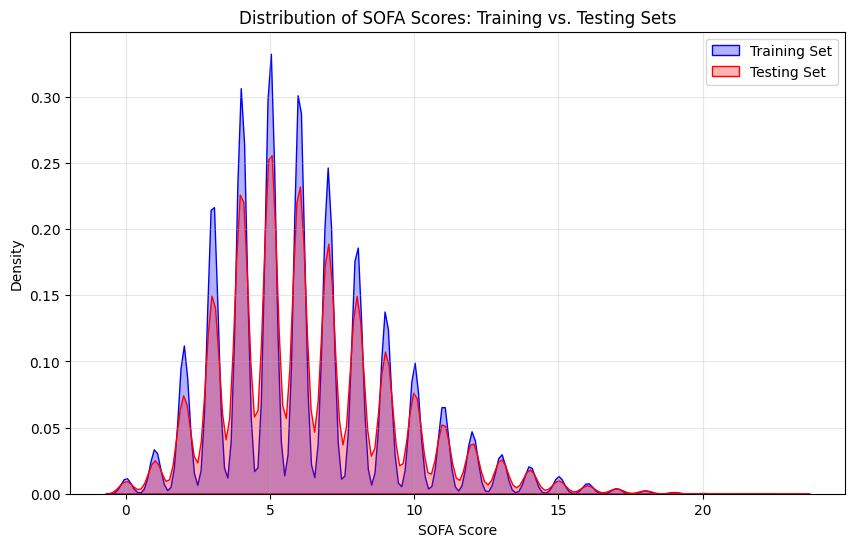


--- TRAIN SET STATISTICS ---
Total Patients (ICU Stays):         11506
Total Transitions (Steps):          1276607
Avg Steps per Patient:              110.95
Mortality Rate:                     %13.01 (1497 deaths)
Intervention Rate (Action > 0):     %19.19
Average SOFA Score:                 6.20

--- Action Distribution (Top 5) ---
action
0   80.81%
1    0.10%
2    0.03%
3    0.02%
4    0.22%

--- TEST SET STATISTICS ---
Total Patients (ICU Stays):         2877
Total Transitions (Steps):          328612
Avg Steps per Patient:              114.22
Mortality Rate:                     %13.07 (376 deaths)
Intervention Rate (Action > 0):     %19.26
Average SOFA Score:                 6.32

--- Action Distribution (Top 5) ---
action
0   80.74%
1    0.12%
2    0.04%
3    0.01%
4    0.23%

Datasets saved:
 - Train: sepsis_rl_train.parquet (1276607 rows)
 - Test : sepsis_rl_test.parquet (328612 rows)


In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedShuffleSplit
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. DATA LOADING
# =========================================================
input_path = 'sepsis_rl.parquet'

if not os.path.exists(input_path):
    raise FileNotFoundError(f"{input_path} not found. Check previous steps.")

print(f"Loading: {input_path}...")
state_df = pd.read_parquet(input_path)
state_df.columns = state_df.columns.astype(str)

# Optional: Fixing action space to 0-3 (Cleaning Action 4)
# print(f"Row count before cleaning: {len(state_df)}")
# state_df = state_df[state_df['action'].isin([0, 1, 2, 3])]
# print(f"Row count after cleaning: {len(state_df)}")

# =========================================================
# 2. STATISTICS FUNCTION
# =========================================================
def print_stats(df, label="GENERAL"):
    # Check for empty dataframe
    if df.empty:
        print(f"\n--- {label} ---")
        print("NO DATA AVAILABLE!")
        return

    # Patients and Steps
    num_patients = df.index.get_level_values(0).nunique()
    num_steps = len(df)
    steps_per_patient = df.groupby(level=0).size()

    # Outcomes (Mortality)
    # Get expire flag from the first row (or any row) of each patient
    mortality_counts = df.groupby(level=0)['hospital_expire_flag'].first().value_counts()
    death_rate = (mortality_counts.get(1, 0) / num_patients) * 100 if num_patients > 0 else 0

    # Clinical Metrics
    avg_sofa = df['sofa'].mean()
    
    # Action Distribution
    action_dist = df['action'].value_counts(normalize=True).sort_index() * 100
    intervention_rate = (df['action'] > 0).mean() * 100

    print(f"\n--- {label} STATISTICS ---")
    print(f"{'Total Patients (ICU Stays):':<35} {num_patients}")
    print(f"{'Total Transitions (Steps):':<35} {num_steps}")
    print(f"{'Avg Steps per Patient:':<35} {steps_per_patient.mean():.2f}")
    print(f"{'Mortality Rate:':<35} %{death_rate:.2f} ({mortality_counts.get(1, 0)} deaths)")
    print(f"{'Intervention Rate (Action > 0):':<35} %{intervention_rate:.2f}")
    print(f"{'Average SOFA Score:':<35} {avg_sofa:.2f}")
    
    print("\n--- Action Distribution (Top 5) ---")
    print(action_dist.head(5).to_string(float_format="%.2f%%"))

# Display initial global statistics
print_stats(state_df, "GLOBAL")

# =========================================================
# 3. STRATIFICATION AND SPLITTING
# =========================================================
print("\nGenerating stratification keys...")

# Create summary profile for each patient
patient_profiles = state_df.groupby(level=0).agg({
    'action': lambda x: x.mode()[0] if not x.mode().empty else 0, # Most frequent action
    'hospital_expire_flag': 'first'   
})

# Stratify Key: Action Mode + Mortality Status
# Example: "0_0" (No treatment & Survived), "1_1" (Treatment & Deceased)
patient_profiles['stratify_key'] = (
    patient_profiles['action'].astype(str) + "_" + 
    patient_profiles['hospital_expire_flag'].astype(str)
)

# Rare Class Management
counts = patient_profiles['stratify_key'].value_counts()
rare_keys = counts[counts < 2].index # Classes with fewer than 2 examples

if not rare_keys.empty:
    print(f"Warning: {len(rare_keys)} rare classes found and merged into 'Other' or majority group.")
    patient_profiles['stratify_key'] = patient_profiles['stratify_key'].replace(rare_keys, "Other")
    
    # If 'Other' group remains singleton, merge into the most common group
    new_counts = patient_profiles['stratify_key'].value_counts()
    if "Other" in new_counts and new_counts["Other"] < 2:
        most_common = new_counts.drop("Other", errors='ignore').idxmax()
        patient_profiles['stratify_key'] = patient_profiles['stratify_key'].replace("Other", most_common)

# Splitting Process
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
ids = patient_profiles.index.values
strat_labels = patient_profiles['stratify_key'].values

train_idx, test_idx = next(sss.split(ids, strat_labels))
train_ids, test_ids = ids[train_idx], ids[test_idx]

# Filtering by ID (Ensuring sorted index)
train_df = state_df.loc[state_df.index.get_level_values(0).isin(train_ids)].sort_index()
test_df = state_df.loc[state_df.index.get_level_values(0).isin(test_ids)].sort_index()

# =========================================================
# 4. SANITY CHECK (Data Leakage Control)
# =========================================================
train_patients = set(train_df.index.get_level_values(0))
test_patients = set(test_df.index.get_level_values(0))
intersection = train_patients.intersection(test_patients)

if len(intersection) > 0:
    raise ValueError(f"ERROR: {len(intersection)} patients exist in both Train and Test sets! (Data Leakage)")
else:
    print("\n✅ SUCCESS: No patient overlap between Train and Test sets.")

# =========================================================
# 5. STATISTICAL VALIDATION (P-VALUE ANALYSIS)
# =========================================================
print("\n--- STATISTICAL VALIDATION (TRAIN vs TEST) ---")

# 1. SOFA Score (Continuous Variable) -> T-Test
# H0: There is no difference between the means of the two groups.
t_stat, p_val_sofa = stats.ttest_ind(train_df['sofa'], test_df['sofa'], equal_var=False)
print(f"SOFA Score (T-Test): P-Value = {p_val_sofa:.4f}")

# 2. Mortality (Categorical) -> Chi-Square Test
# H0: Mortality rates are consistent across groups.
mortality_table = [
    [train_df['hospital_expire_flag'].sum(), len(train_df) - train_df['hospital_expire_flag'].sum()],
    [test_df['hospital_expire_flag'].sum(), len(test_df) - test_df['hospital_expire_flag'].sum()]
]
chi2, p_val_mortality, _, _ = stats.chi2_contingency(mortality_table)
print(f"Mortality (Chi-Square): P-Value = {p_val_mortality:.4f}")

# 3. Intervention Rate (Categorical) -> Chi-Square Test
# H0: Frequency of interventions (Action > 0) is consistent across groups.
train_interventions = (train_df['action'] > 0).sum()
test_interventions = (test_df['action'] > 0).sum()
intervention_table = [
    [train_interventions, len(train_df) - train_interventions],
    [test_interventions, len(test_df) - test_interventions]
]
chi2_int, p_val_intervention, _, _ = stats.chi2_contingency(intervention_table)
print(f"Intervention Rate (Chi-Square): P-Value = {p_val_intervention:.4f}")

# Interpretation
print("-" * 30)
if all(p > 0.05 for p in [p_val_sofa, p_val_mortality, p_val_intervention]):
    print("✅ RESULT: P-values > 0.05. No statistically significant difference between Train and Test sets. Distributions are homogeneous.")
else:
    print("⚠️ WARNING: Differences detected in some metrics (P < 0.05). Review the split process.")

# =========================================================
# 6. VISUAL PROOF (HISTOGRAM)
# =========================================================
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['sofa'], label='Training Set', fill=True, color='blue', alpha=0.3)
sns.kdeplot(test_df['sofa'], label='Testing Set', fill=True, color='red', alpha=0.3)
plt.title('Distribution of SOFA Scores: Training vs. Testing Sets')
plt.xlabel('SOFA Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final output and save
print_stats(train_df, "TRAIN SET")
print_stats(test_df, "TEST SET")

train_df.to_parquet('sepsis_rl_train.parquet')
test_df.to_parquet('sepsis_rl_test.parquet')

print("\nDatasets saved:")
print(f" - Train: sepsis_rl_train.parquet ({len(train_df)} rows)")
print(f" - Test : sepsis_rl_test.parquet ({len(test_df)} rows)")


2x2 cql

<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

# Step 9: Offline Policy Training (CQL)

In this phase, we train the **AI Agent** using a Conservative Q-Learning approach. Unlike standard Q-Learning, CQL addresses the "overestimation bias" inherent in offline datasets by penalizing Q-values for actions not seen in the clinical data.

## 1. The Architecture: CQL Agent
The agent utilizes a Deep Q-Network ($Q$) with the following components:
* **Target Network:** A slowly updated copy of the policy network to stabilize the Bellman updates.
* **Conservative Loss:** The loss function is modified to include a penalty term:
    $$\mathcal{L}_{CQL} = \mathcal{L}_{Bellman} + \alpha \cdot \left( \log \sum_a \exp(Q(s, a)) - \mathbb{E}_{a \sim \pi_{\beta}}[Q(s, a)] \right)$$



## 2. Hyperparameter Optimization (Optuna)
We employ **Bayesian Optimization** to find the ideal values for:
* **Learning Rate ($\eta$):** Balancing convergence speed and stability.
* **Gamma ($\gamma$):** The discount factor for future rewards.
* **CQL Alpha ($\alpha$):** The strength of the conservative penalty.



## 3. Evaluation & Visualization
Once training is complete, we evaluate the agent's behavior across three dimensions:
1.  **Training Loss:** Monitoring convergence of the Bellman and CQL errors.
2.  **Average Q-Value:** Tracking the expected long-term cumulative reward.
3.  **Action Distribution:** Comparing the AI's treatment frequency (Fluids, Vasopressors, etc.) against historical clinician decisions.

<div style="padding: 10px; border-radius: 5px; border: 1px solid;">
    <strong>Clinical Intent:</strong> The logarithmic scale in the action distribution is crucial. It allows us to see if the AI is suggesting "Combo" treatments or "Vasopressors" in rare, high-acuity cases where a clinician might have been more hesitant.
</div>

</div>

🔥 Running on: cuda
📂 Searching for dataset: 'sepsis_rl_train.parquet'
✅ File found. Loading...
⚖️ Scaling data...
🚀 Processing data into Buffer...
✅ Done. Buffer Size: 1265101

💎 Found saved parameters: cql_best_params.json
   ► Loaded Parameters: {'lr': 0.00038895094276280277, 'gamma': 0.9613393049513855, 'cql_alpha': 1.8534485540719308, 'tau': 0.006583471114493862}

🚀 TRAINING STARTED (LR=3.89e-04, Gamma=0.961, Alpha=1.853)


Epoch 1/10: 100%|██████████| 2000/2000 [00:16<00:00, 119.19it/s, loss=3.30, q=5.5]


Epoch 1 | Avg Loss: 3.170 | Avg Q: 3.10


Epoch 2/10: 100%|██████████| 2000/2000 [00:16<00:00, 124.62it/s, loss=3.51, q=8.6]


Epoch 2 | Avg Loss: 3.504 | Avg Q: 7.09


Epoch 3/10: 100%|██████████| 2000/2000 [00:15<00:00, 129.55it/s, loss=3.68, q=9.9] 


Epoch 3 | Avg Loss: 3.800 | Avg Q: 9.28


Epoch 4/10: 100%|██████████| 2000/2000 [00:15<00:00, 125.58it/s, loss=4.22, q=10.8]


Epoch 4 | Avg Loss: 4.031 | Avg Q: 10.47


Epoch 5/10: 100%|██████████| 2000/2000 [00:15<00:00, 128.61it/s, loss=3.78, q=11.2]


Epoch 5 | Avg Loss: 4.145 | Avg Q: 11.09


Epoch 6/10: 100%|██████████| 2000/2000 [00:16<00:00, 124.71it/s, loss=4.13, q=11.7]


Epoch 6 | Avg Loss: 4.188 | Avg Q: 11.45


Epoch 7/10: 100%|██████████| 2000/2000 [00:15<00:00, 127.90it/s, loss=4.27, q=11.9]


Epoch 7 | Avg Loss: 4.267 | Avg Q: 11.67


Epoch 8/10: 100%|██████████| 2000/2000 [00:16<00:00, 124.11it/s, loss=3.87, q=12.0]


Epoch 8 | Avg Loss: 4.279 | Avg Q: 11.79


Epoch 9/10: 100%|██████████| 2000/2000 [00:16<00:00, 123.80it/s, loss=4.93, q=11.9]


Epoch 9 | Avg Loss: 4.288 | Avg Q: 11.87


Epoch 10/10: 100%|██████████| 2000/2000 [00:16<00:00, 123.76it/s, loss=4.39, q=11.9]


Epoch 10 | Avg Loss: 4.339 | Avg Q: 11.89

💾 Model saved: cql_sepsis_model_final.pth

📊 Visualizing Results...
   -> Calculating action distribution on full dataset...


/tmp/ipykernel_261169/1571938747.py:352: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['None', 'Fluids', 'Vaso', 'Combo'], fontsize=TICK_SIZE)
/tmp/ipykernel_261169/1571938747.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_yticklabels(axes[2].get_yticks(), fontsize=TICK_SIZE) # Y ekseni sayıları


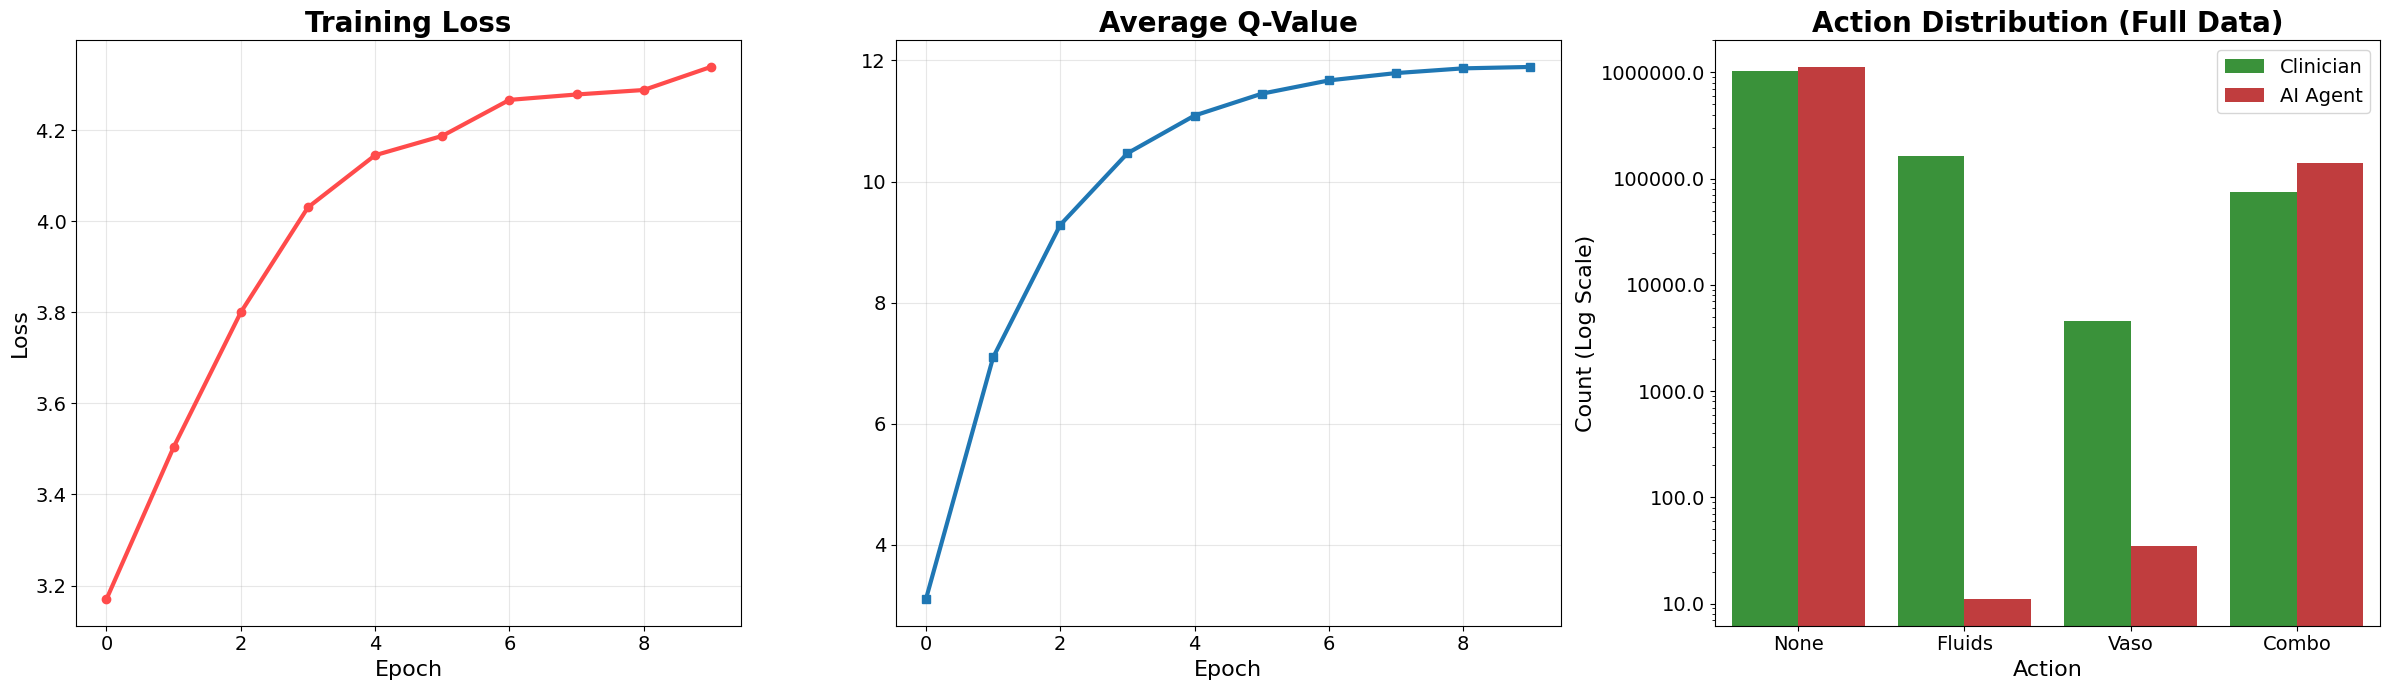

✅ All processes completed successfully.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import json  # <-- JSON library added
import pickle # Keeping only for the scaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import optuna

# ==============================================================================
# 0. SETTINGS AND GLOBAL VARIABLES
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Running on: {DEVICE}")

# File Paths
PARAMS_FILE = "cql_best_params.json"  # <-- Changed to JSON
DATA_FILE = "sepsis_rl_train.parquet"
SCALER_FILE = "sepsis_scaler.pkl"
MODEL_FILE = "cql_sepsis_model_final.pth"

# Fixed Parameters
BATCH_SIZE = 1024         
NUM_EPOCHS = 10           
STEPS_PER_EPOCH = 2000 
HIDDEN_DIM = 256 
ACTION_DIM = 4

# --- 12 FEATURES ---
FEATURE_COLS = [
    '220045', '220052', '220210', '220277', '50813', '50885', 
    '50912', '51265', '220224', '223835', '226755', # 'sofa' - GCS corrected
]
STATE_DIM = len(FEATURE_COLS)

# Default Hyperparameters (Will be updated from file or Optuna)
LR = 1.1e-4                
GAMMA = 0.95893              
TAU = 0.00174                 
CQL_ALPHA = 1.0           

# ==============================================================================
# 1. MODEL AND BUFFER CLASSES
# ==============================================================================
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.fc(x)

class TorchReplayBuffer:
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = torch.tensor(states, device=DEVICE)
        self.actions = torch.tensor(actions, device=DEVICE).long()
        self.rewards = torch.tensor(rewards, device=DEVICE)
        self.next_states = torch.tensor(next_states, device=DEVICE)
        self.dones = torch.tensor(dones, device=DEVICE)
        self.size = self.states.shape[0]

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=DEVICE)
        return (
            self.states[idx],
            self.actions[idx].unsqueeze(1),
            self.rewards[idx].unsqueeze(1),
            self.next_states[idx],
            self.dones[idx].unsqueeze(1)
        )

class CQLAgent:
    def __init__(self, state_dim, action_dim, lr=LR, tau=TAU, gamma=GAMMA, cql_alpha=CQL_ALPHA):
        self.tau = tau
        self.gamma = gamma
        self.cql_alpha = cql_alpha
        
        self.policy = torch.compile(QNetwork(state_dim, action_dim).to(DEVICE))
        self.target = torch.compile(QNetwork(state_dim, action_dim).to(DEVICE))
        self.target.load_state_dict(self.policy.state_dict())
        self.target.eval()

        self.optim = optim.Adam(self.policy.parameters(), lr=lr, eps=1e-4)
        self.scaler = torch.amp.GradScaler('cuda')
    
    def soft_update(self):
        for target_param, policy_param in zip(self.target.parameters(), self.policy.parameters()):
            target_param.data.copy_(
                self.tau * policy_param.data + (1.0 - self.tau) * target_param.data
            )
            
    def update(self, buffer, batch_size=BATCH_SIZE):
        states, actions, rewards, next_states, dones = buffer.sample(batch_size)

        with torch.no_grad():
            next_actions = self.policy(next_states).argmax(1, keepdim=True)
            next_q = self.target(next_states).gather(1, next_actions)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            q_all = self.policy(states)
            q_data = q_all.gather(1, actions)

            bellman = F.mse_loss(q_data, target_q)
            cql = torch.logsumexp(q_all, dim=1).mean() - q_data.mean()
            loss = bellman + self.cql_alpha * cql

        self.optim.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optim)
        self.scaler.update()

        self.soft_update()

        return loss.item(), q_data.mean().item()

# ==============================================================================
# 2. DATA LOADING AND PREPARATION
# ==============================================================================
def load_and_process_data():
    torch.set_float32_matmul_precision("high")
    print(f"📂 Searching for dataset: '{DATA_FILE}'")

    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError("Parquet file not found!")
        
    print(f"✅ File found. Loading...")
    train_df = pd.read_parquet(DATA_FILE)
    
    # ID Correction
    if 'icustay_id' not in train_df.columns:
        if train_df.index.name == 'icustay_id' or 'icustay_id' in train_df.index.names:
            train_df = train_df.reset_index()
        elif 'stay_id' in train_df.columns:
            train_df = train_df.rename(columns={'stay_id': 'icustay_id'})
        else:
            raise KeyError("'icustay_id' not found!")

    train_df = train_df.sort_values(by=['icustay_id','t_bin'])
    
    # Normalization
    print("⚖️ Scaling data...")
    scaler = StandardScaler()
    train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS])
    with open(SCALER_FILE, 'wb') as f: pickle.dump(scaler, f)

    # Action Mapping
    print("🚀 Processing data into Buffer...")
    action_vals = train_df['action'].values
    f_level = action_vals // 5
    v_level = action_vals % 5
    conditions = [(f_level==0)&(v_level==0), (f_level>0)&(v_level==0), (f_level==0)&(v_level>0)]
    choices = [0, 1, 2]
    train_df['processed_action'] = np.select(conditions, choices, default=3)

    # Next State & Done
    next_state_cols = [f"{c}_next" for c in FEATURE_COLS]
    train_df[next_state_cols] = train_df[FEATURE_COLS].shift(-1)
    train_df['next_icustay_id'] = train_df['icustay_id'].shift(-1)
    train_df['next2_icustay_id'] = train_df['icustay_id'].shift(-2)

    valid_mask = (train_df['icustay_id'] == train_df['next_icustay_id'])
    done_mask = (valid_mask) & (train_df['icustay_id'] != train_df['next2_icustay_id'])

    train_df['done'] = 0.0
    train_df.loc[done_mask, 'done'] = 1.0

    valid_data = train_df[valid_mask].copy()

    # Numpy Transfer
    states = valid_data[FEATURE_COLS].values.astype(np.float32)
    actions = valid_data['processed_action'].values.astype(np.int64)
    rewards = valid_data['reward'].values.astype(np.float32)
    next_states = valid_data[next_state_cols].values.astype(np.float32)
    dones = valid_data['done'].values.astype(np.float32)

    buffer = TorchReplayBuffer(states, actions, rewards, next_states, dones)
    print(f"✅ Done. Buffer Size: {buffer.size}")
    return buffer

# ==============================================================================
# 3. HYPERPARAMETER OPTIMIZATION (OPTUNA)
# ==============================================================================
def evaluate_policy(agent, buffer, n_samples=5000):
    idx = np.random.choice(buffer.size, min(n_samples, buffer.size), replace=False)
    states = buffer.states[idx]
    actions = buffer.actions[idx]

    with torch.no_grad():
        q = agent.policy(states)
        preds = q.argmax(dim=1)

    doctor_dist = torch.bincount(actions, minlength=ACTION_DIM).float()
    ai_dist = torch.bincount(preds, minlength=ACTION_DIM).float()

    doctor_dist /= doctor_dist.sum()
    ai_dist /= ai_dist.sum()

    divergence = torch.abs(doctor_dist - ai_dist).sum().item()
    avg_q = q.mean().item()

    return divergence, avg_q

def objective(trial, buffer):
    lr = trial.suggest_float("lr", 5e-5, 5e-4, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    cql_alpha = trial.suggest_float("cql_alpha", 0.1, 2.0) 
    tau = trial.suggest_float("tau", 0.001, 0.01)

    agent = CQLAgent(STATE_DIM, ACTION_DIM, lr=lr, tau=tau, gamma=gamma, cql_alpha=cql_alpha)

    # Warmup round (1000 steps)
    for _ in range(1000):
        agent.update(buffer)

    divergence, avg_q = evaluate_policy(agent, buffer)
    
    # Score: Minimize divergence, but penalize exploding Q-values
    score = divergence + 0.01 * (abs(avg_q) if abs(avg_q) > 100 else 0) 
    return score

# ==============================================================================
# 4. MAIN FLOW
# ==============================================================================
if __name__ == "__main__":
    # 1. Load Data
    buffer = load_and_process_data()

    # 2. Check Hyperparameters (JSON)
    if os.path.exists(PARAMS_FILE):
        print(f"\n💎 Found saved parameters: {PARAMS_FILE}")
        with open(PARAMS_FILE, "r") as f:
            best_params = json.load(f) # <-- JSON Load
        print(f"   ► Loaded Parameters: {best_params}")
    else:
        print(f"\n🔍 Parameter file not found. Starting Optuna optimization...")
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, buffer), n_trials=100) 
        
        best_params = study.best_params
        print(f"\n🏆 Best Parameters Found: {best_params}")
        
        # Save as JSON
        with open(PARAMS_FILE, "w") as f:
            json.dump(best_params, f, indent=4) # <-- JSON Save (indent for readability)
            print("💾 Parameters saved as JSON.")

    # Assign to Global Variables
    LR = best_params.get("lr", LR)
    GAMMA = best_params.get("gamma", GAMMA)
    TAU = best_params.get("tau", TAU)
    CQL_ALPHA = best_params.get("cql_alpha", CQL_ALPHA)

    # 3. Main Training Loop
    print(f"\n🚀 TRAINING STARTED (LR={LR:.2e}, Gamma={GAMMA:.3f}, Alpha={CQL_ALPHA:.3f})")
    
    agent = CQLAgent(STATE_DIM, ACTION_DIM, lr=LR, tau=TAU, gamma=GAMMA, cql_alpha=CQL_ALPHA)
    history = {"loss": [], "avg_q": []}

    for ep in range(NUM_EPOCHS):
        loss_sum, q_sum = 0, 0
        pbar = tqdm(range(STEPS_PER_EPOCH), desc=f"Epoch {ep+1}/{NUM_EPOCHS}")

        for _ in pbar:
            loss, q = agent.update(buffer)
            loss_sum += loss
            q_sum += q
            pbar.set_postfix(loss=f"{loss:.2f}", q=f"{q:.1f}")

        # Add stats to history
        epoch_loss = loss_sum / STEPS_PER_EPOCH
        epoch_q = q_sum / STEPS_PER_EPOCH
        history["loss"].append(epoch_loss)
        history["avg_q"].append(epoch_q)
        
        print(f"Epoch {ep+1} | Avg Loss: {epoch_loss:.3f} | Avg Q: {epoch_q:.2f}")

    torch.save(agent.policy.state_dict(), MODEL_FILE)
    print(f"\n💾 Model saved: {MODEL_FILE}")

    # 4. Visualization (Full Data & Corrected)
print("\n📊 Visualizing Results...")

# Figsize'ı biraz daha kareye yakın veya geniş tutabiliriz, yazı büyüyünce alan gerekebilir.
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Yüksekliği 6'dan 7'ye çıkardım

# --- Genel Font Ayarları ---
TITLE_SIZE = 20
LABEL_SIZE = 16
TICK_SIZE = 14
LEGEND_SIZE = 14

# 1. Loss Plot
axes[0].plot(history['loss'], color='#FF4B4B', linewidth=3, marker='o') # Çizgi kalınlığını da artırdım (2.5 -> 3)
axes[0].set_title("Training Loss", fontsize=TITLE_SIZE, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=LABEL_SIZE)
axes[0].set_ylabel("Loss", fontsize=LABEL_SIZE)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_SIZE) # Eksen sayılarının boyutu
axes[0].grid(True, alpha=0.3)

# 2. Q-Value Plot
axes[1].plot(history['avg_q'], color='#1F77B4', linewidth=3, marker='s')
axes[1].set_title("Average Q-Value", fontsize=TITLE_SIZE, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=LABEL_SIZE)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_SIZE) # Eksen sayılarının boyutu
axes[1].grid(True, alpha=0.3)

# 3. Action Distribution (FULL DATA)
print("   -> Calculating action distribution on full dataset...")

# Predict in batches to prevent GPU Memory Error
all_ai_preds = []
eval_batch_size = 50000
total_samples = buffer.size

agent.policy.eval()
with torch.no_grad():
    for i in range(0, total_samples, eval_batch_size):
        batch_states = buffer.states[i : i + eval_batch_size]
        preds = agent.policy(batch_states).argmax(dim=1).cpu().numpy()
        all_ai_preds.append(preds)
        
all_ai_preds = np.concatenate(all_ai_preds)
all_true_actions = buffer.actions.cpu().numpy()

df_combined = pd.concat([
    pd.DataFrame({'Action': all_true_actions, 'Source': 'Clinician'}),
    pd.DataFrame({'Action': all_ai_preds, 'Source': 'AI Agent'})
])

sns.countplot(
    x='Action', 
    hue='Source', 
    data=df_combined, 
    ax=axes[2], 
    palette={'Clinician': '#2ca02c', 'AI Agent': '#d62728'},
    order=[0, 1, 2, 3]
)

axes[2].set_yscale("log")
axes[2].set_title(f"Action Distribution (Full Data)", fontsize=TITLE_SIZE, fontweight='bold')
axes[2].set_xticklabels(['None', 'Fluids', 'Vaso', 'Combo'], fontsize=TICK_SIZE)
axes[2].set_yticklabels(axes[2].get_yticks(), fontsize=TICK_SIZE) # Y ekseni sayıları
axes[2].set_ylabel("Count (Log Scale)", fontsize=LABEL_SIZE)
axes[2].set_xlabel("Action", fontsize=LABEL_SIZE)
axes[2].legend(loc='upper right', fontsize=LEGEND_SIZE, title_fontsize=LEGEND_SIZE)

plt.tight_layout()
plt.show()
print("✅ All processes completed successfully.")


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

# Step 10: Model Validation & Clinician Alignment

In this final phase, we evaluate the trained **CQL Agent** on a held-out test set ($20\%$ of the data) that the model has never seen. The goal is to measure how closely the AI's recommendations align with historical clinician decisions and to identify where the AI deviates.

## 1. The Evaluation Metric: "Match Rate"
Unlike standard classification, a $100\%$ match rate is not necessarily the goal. Reinforcement Learning aims to find an *optimal* policy, which may differ from the *average* clinician's behavior. We look for:
* **Consistency:** Does the agent recommend "None" or "Fluids" in similar proportions to experts?
* **Safety:** Does the agent avoid suggesting high-dose interventions (Combo/Vaso) in stable patients?



## 2. Action Mapping & Normalization
To ensure a fair comparison, we binned the $25$ raw clinician actions into the same $4$ categories used by the model:
* **None (0):** No active fluid or vasopressor intervention.
* **Fluids (1):** Intravenous fluid boluses.
* **Vasopressors (2):** Drugs to increase blood pressure (e.g., Norepinephrine).
* **Combo (3):** Simultaneous administration of both fluids and vasopressors.

Preparing test data...
✅ Model loaded successfully (_orig_mod cleaned)
Predicting for a total of 328612 rows...

Match Rate with Clinician: %76.18


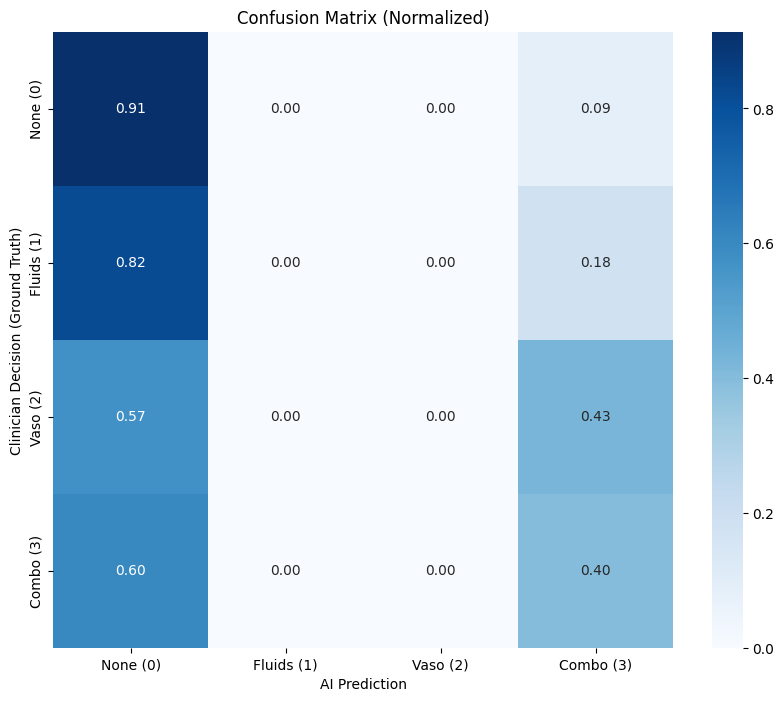

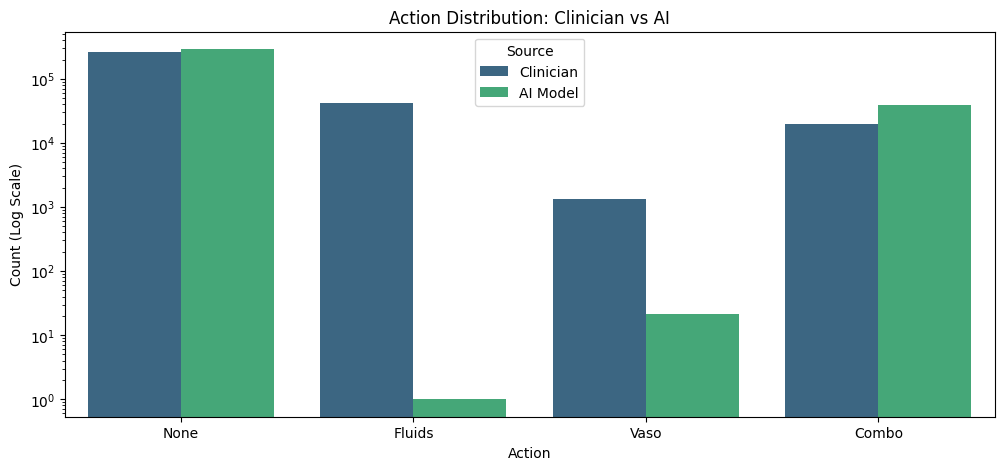


--- DETAILED REPORT ---
              precision    recall  f1-score   support

    None (0)       0.84      0.91      0.87    265335
  Fluids (1)       0.00      0.00      0.00     42198
    Vaso (2)       0.05      0.00      0.00      1314
   Combo (3)       0.20      0.40      0.27     19765

    accuracy                           0.76    328612
   macro avg       0.27      0.33      0.29    328612
weighted avg       0.69      0.76      0.72    328612



In [26]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# =========================================================
# 1. PREPARE TEST DATA
# =========================================================
print("Preparing test data...")

# Load files
train_df = pd.read_parquet('sepsis_rl_train.parquet').reset_index()
test_df = pd.read_parquet('sepsis_rl_test.parquet').reset_index()

# --- TRANSFORMATION USING SAME LOGIC AS TRAINING ---
# Same operation done with np.select in your training code:
def convert_to_4_bins(df):
    action_vals = df['action'].values
    f_level = action_vals // 5
    v_level = action_vals % 5
    
    conditions = [
        (f_level==0)&(v_level==0), # Action 0: None
        (f_level>0)&(v_level==0),  # Action 1: Fluids
        (f_level==0)&(v_level>0)   # Action 2: Vaso
    ]
    choices = [0, 1, 2]
    # Remainder (Action 3): Combo
    return np.select(conditions, choices, default=3)

# Convert real clinician decisions in test set (0-24) -> (0-3) format
# So we can compare them with the model's predictions.
test_df['binned_action'] = convert_to_4_bins(test_df)

# Feature List (Must be identical to training)
feature_cols = [
    '220045', '220052', '220210', '220277', '50813', '50885', 
    '50912', '51265', '220224', '223835', '226755',# 'sofa'
]

# Handling Missing Values (NaN Cleaning)
train_df[feature_cols] = train_df[feature_cols].fillna(0)
test_df[feature_cols] = test_df[feature_cols].fillna(0)

# Scaling (Fit on training data, transform test data)
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

# Ground Truth
y_true = test_df['binned_action'].values

# =========================================================
# 2. LOAD MODEL (NOW HAS 4 OUTPUTS)
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(feature_cols)
output_dim = 4  # <--- CRITICAL CHANGE: Must be 4 because training code used 4.

class QNetwork(torch.nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),  # No Dropout in training code, removed here
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_dim)
        )
    def forward(self, x): return self.fc(x)

model = QNetwork(input_dim, output_dim).to(device)

try:
    raw_state_dict = torch.load(
        "cql_sepsis_model_final.pth",
        map_location=device
    )

    # Clean the _orig_mod. prefix caused by torch.compile
    clean_state_dict = {
        k.replace("_orig_mod.", ""): v
        for k, v in raw_state_dict.items()
    }

    model.load_state_dict(clean_state_dict)
    print("✅ Model loaded successfully (_orig_mod cleaned)")
except Exception as e:
    print(f"⚠️ ERROR: Model could not be loaded.\nDetail: {e}")

# =========================================================
# 3. MAKE PREDICTIONS
# =========================================================
model.eval()
y_pred = []

print(f"Predicting for a total of {len(X_test)} rows...")
with torch.no_grad():
    batch_size = 1024
    for i in range(0, len(X_test), batch_size):
        batch_X = torch.FloatTensor(X_test[i:i+batch_size]).to(device)
        outputs = model(batch_X)
        
        # Model directly produces 0,1,2,3. No conversion needed.
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

y_pred = np.array(y_pred)

# =========================================================
# 4. VISUALIZE RESULTS
# =========================================================
target_names = ['None (0)', 'Fluids (1)', 'Vaso (2)', 'Combo (3)']

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nMatch Rate with Clinician: %{acc*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Normalize (Row-based - Distribution according to Clinician's decision)
row_sums = cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.divide(cm.astype('float'), row_sums, out=np.zeros_like(cm.astype('float')), where=row_sums!=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('AI Prediction')
plt.ylabel('Clinician Decision (Ground Truth)')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# Action Distribution
plt.figure(figsize=(12, 5))
data_comp = pd.DataFrame({
    'Action': np.concatenate([y_true, y_pred]),
    'Source': ['Clinician'] * len(y_true) + ['AI Model'] * len(y_pred)
})
sns.countplot(x='Action', hue='Source', data=data_comp, palette='viridis')
plt.xticks(ticks=[0,1,2,3], labels=['None', 'Fluids', 'Vaso', 'Combo'])
plt.title("Action Distribution: Clinician vs AI")
plt.yscale('log') # Log scale, to see minority classes
plt.ylabel("Count (Log Scale)")
plt.show()

print("\n--- DETAILED REPORT ---")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

# Step 11: Explainable RL (XRL) with SHAP

In clinical settings, "black-box" models are difficult to trust. To bridge this gap, we use **SHAP analysis** to decompose the agent's Q-values. This allows us to see exactly which physiological features (e.g., Lactate levels, MAP, or GCS) are driving the agent to recommend specific interventions.

## 1. How SHAP Works in RL
For each treatment option, the agent calculates a $Q(s, a)$ value. SHAP assigns a "contribution score" to each input feature, such that the sum of these scores explains the difference between the actual prediction and the average prediction:

$$\text{Output} = \text{Base Value} + \sum_{i=1}^{n} \phi_i$$

Where $\phi_i$ represents the SHAP value for feature $i$.



## 2. Clinical Feature Mapping
We map raw MIMIC-IV item IDs to human-readable clinical terms to make the analysis actionable for medical professionals:
* **50813:** Lactate (Metabolic stress)
* **220052:** MAP (Hemodynamic stability)
* **226755:** GCS (Neurological status)

## 3. Visualizing Policy Drivers
The resulting **Summary Plots** reveal the global behavior of the agent. For example, we can verify if the agent correctly associates high Lactate levels with a higher Q-value for "Fluids" or "Vasopressors."



<div style="padding: 10px; border-radius: 5px; border: 1px solid;">
    <strong>Clinical Intent:</strong> By examining the "Combo" action SHAP plot, we can determine if the agent has learned "synergy." If both low MAP and high Lactate significantly boost the Q-value for the combined treatment, the agent is successfully identifying multi-system organ failure.
</div>

</div>

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Calculating SHAP analysis for 11 features...


100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


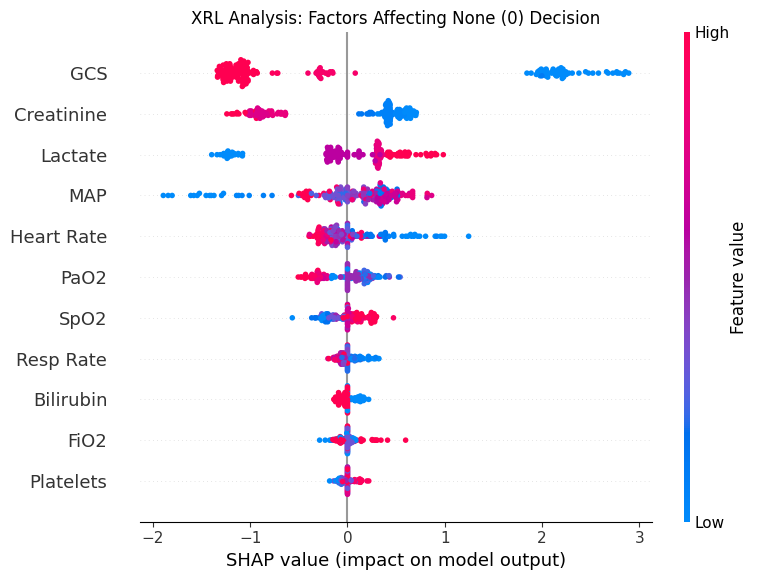

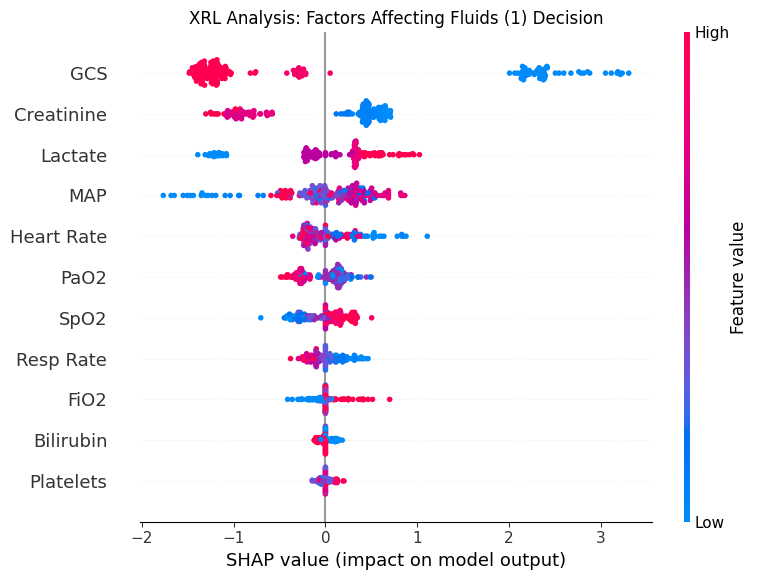

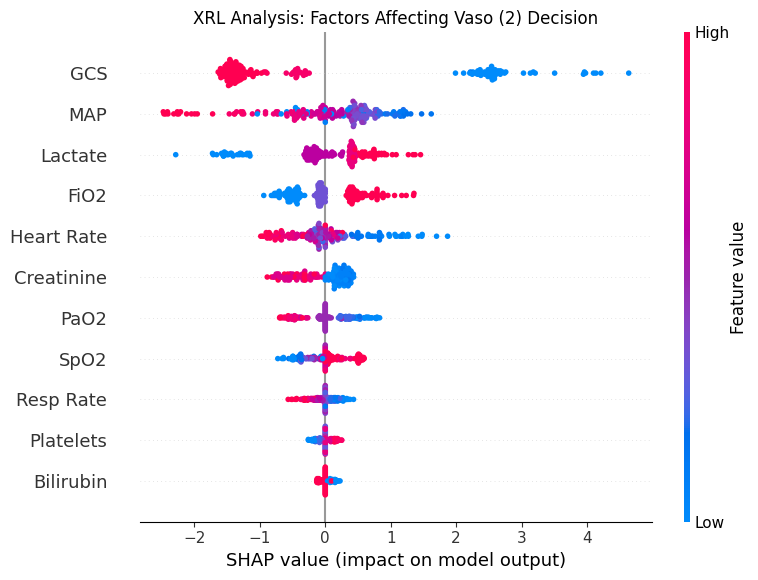

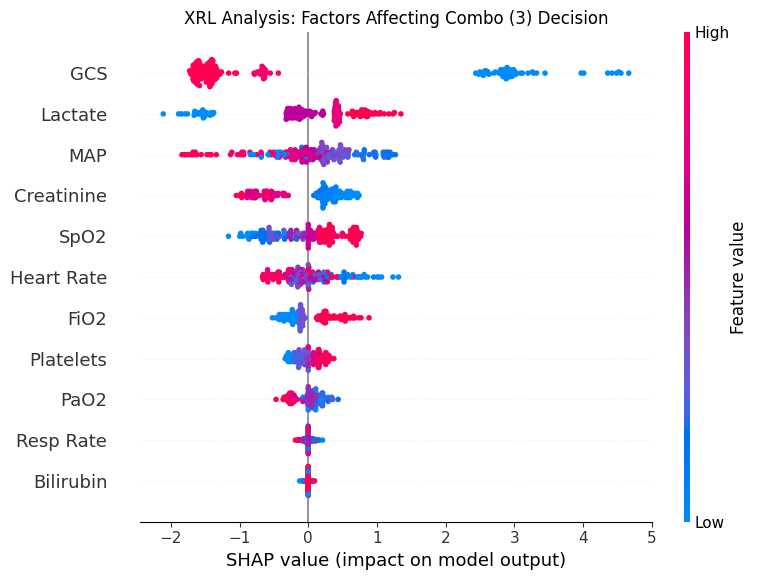

In [27]:
import shap
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Full List of Features (Must be in the same order as training)
states = buffer.states
actions = buffer.actions
feature_names_mapping = {
    '220045': 'Heart Rate', '220052': 'MAP', '220210': 'Resp Rate',
    '220277': 'SpO2', '50813': 'Lactate', '50885': 'Bilirubin',
    '50912': 'Creatinine', '51265': 'Platelets', '220224': 'PaO2',
    '223835': 'FiO2', '226755': 'GCS'
}
friendly_names = [feature_names_mapping.get(col, col) for col in FEATURE_COLS]

# 2. Data Preparation and Dimension Check
if torch.is_tensor(states):
    states_np = states.detach().cpu().numpy()
else:
    states_np = np.array(states)

# IMPORTANT: Ensure states_np contains only the columns expected by the model (11 items)
# If states_np contains extra index/id columns, this will raise an error.
X_sample = states_np[:200, :len(FEATURE_COLS)] 
shap_df = pd.DataFrame(X_sample, columns=friendly_names)

# 3. Model Prediction Function
def model_predict(data_nparray):
    data_tensor = torch.FloatTensor(data_nparray).to(DEVICE)
    with torch.no_grad():
        q_values = agent.policy(data_tensor)
    return q_values.cpu().numpy()

# 4. SHAP Calculation
print(f"Calculating SHAP analysis for {len(friendly_names)} features...")
explainer = shap.KernelExplainer(model_predict, shap_df)
shap_values = explainer.shap_values(shap_df)

# 5. Error-Preventing Visualization Block
action_labels = ['None (0)', 'Fluids (1)', 'Vaso (2)', 'Combo (3)']

for i, action_name in enumerate(action_labels):
    plt.figure(figsize=(10, 6))
    
    # Force SHAP values into a numpy array to check for dimension mismatch
    # KernelExplainer might return a list [i], or an array [:,:,i] or [:,i,:]
    if isinstance(shap_values, list):
        current_val = np.array(shap_values[i])
    else:
        current_val = np.array(shap_values[:, :, i])

    # If SHAP still contains an extra column (bias term), trim it
    if current_val.shape[1] > len(friendly_names):
        current_val = current_val[:, :len(friendly_names)]
    
    plt.title(f"XRL Analysis: Factors Affecting {action_name} Decision", fontsize=12)
    
    # Pass numpy array and DataFrame directly to avoid triggering legacy mode warnings
    shap.summary_plot(
        current_val, 
        shap_df, 
        feature_names=friendly_names,
        show=False
    )
    plt.tight_layout()
    plt.show()


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

# Step 12: Policy Deviation & Mortality Impact Analysis

This final analytical step moves beyond simple accuracy and looks at **clinical utility**. We decompose the discrete actions back into their physiological components (Fluids and Vasopressors) to determine the "cost" of deviating from the AI's suggested treatment path.

## 1. Action Decomposition
The agent operates in a 25-dimensional action space (a $5 \times 5$ matrix). To make the results interpretable for doctors, we map these IDs back to their original dosage tiers:
* **Fluid Doses:** Tiers 0–4 (None to High Volume).
* **Vasopressor Doses:** Tiers 0–4 (None to High Rate).



## 2. The Mortality "U-Curve"
A key hypothesis in Offline RL for healthcare is that mortality follows a **U-shaped curve** relative to policy deviation. 
* **If the Clinician gives significantly MORE than the AI recommends:** Mortality may rise due to fluid overload or vasopressor toxicity.
* **If the Clinician gives significantly LESS than the AI recommends:** Mortality may rise due to untreated hypotension or dehydration.




STARTING CQL ANALYSIS MODULE...
Number of patient states to analyze: 328612
State Dimension Used: 11
Processing device: cuda
Loading model weights...
Model successfully loaded and moved to GPU!
Predictions completed.


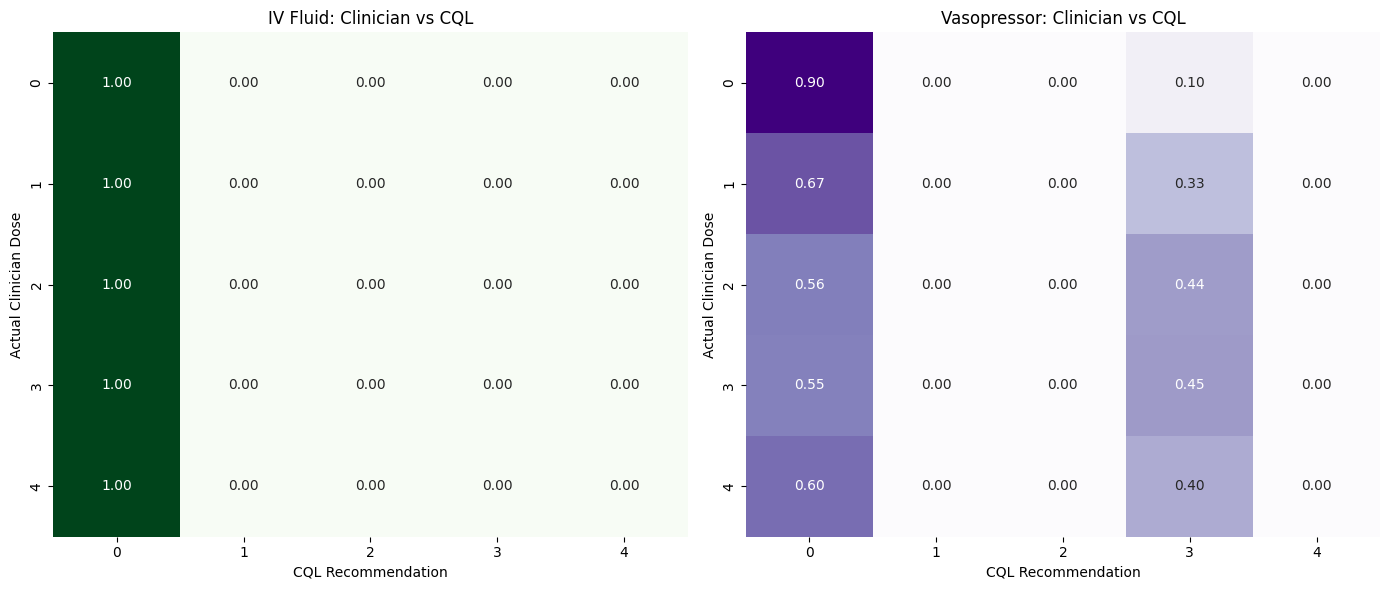

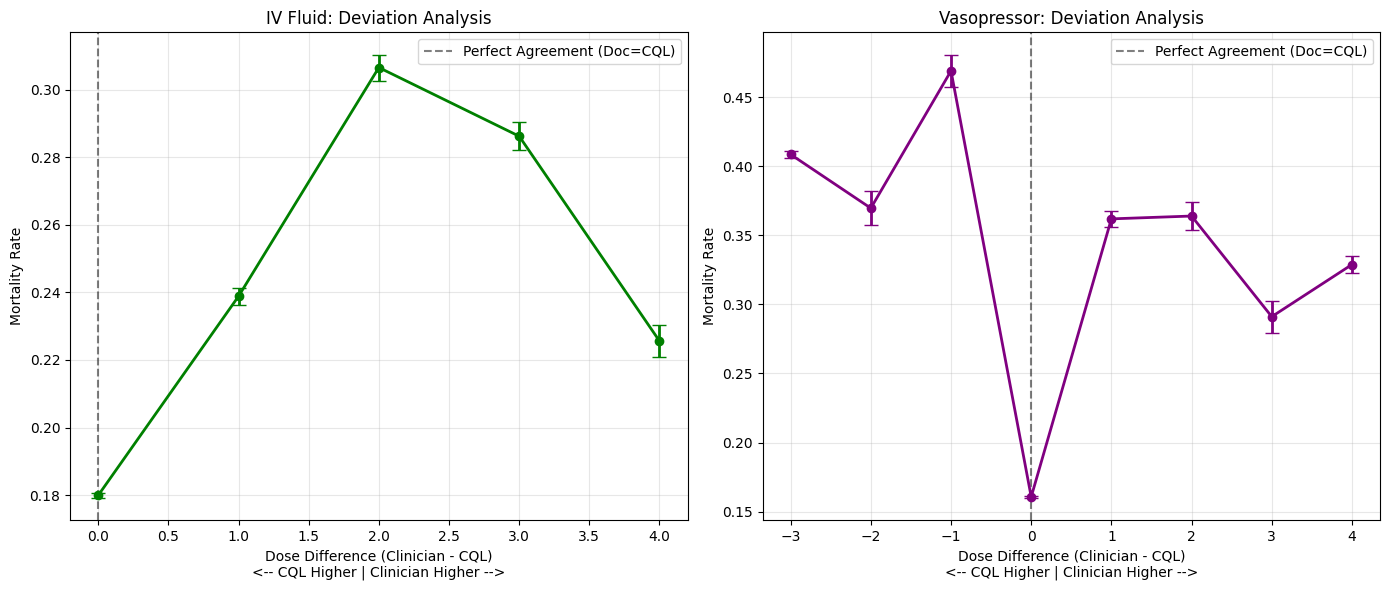

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import os
import torch 
from sklearn.preprocessing import StandardScaler

# =========================================================
# 1. DATA PREPARATION AND ENVIRONMENT CHECK
# =========================================================
print("STARTING CQL ANALYSIS MODULE...")

# Load test data or use existing
test_df = pd.read_parquet('sepsis_rl_test.parquet')
train_df = pd.read_parquet('sepsis_rl_train.parquet')
    
analysis_df = test_df.copy()

state_cols = [
    '220045', '220052', '220210', '220277', '50813', '50885', 
    '50912', '51265', '220224', '223835', '226755'
]

# Scaling (Fit on training data, transform test data)
scaler = StandardScaler()
scaler.fit(train_df[state_cols])
X_test = scaler.transform(test_df[state_cols])

print(f"Number of patient states to analyze: {len(analysis_df)}")
print(f"State Dimension Used: {X_test.shape[1]}")

# =========================================================
# 2. LOAD CQL MODEL AND PREDICT (INTEGRATION)
# =========================================================

# --- SCENARIO B: Using Custom PyTorch Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Processing device: {device}")

# --- Load Custom PyTorch Model ---
# We assume the model architecture (QNetwork) is already defined in memory
print("Loading model weights...")

# Load weights
state_dict = torch.load("cql_sepsis_model_final.pth", map_location=device)

# Clean up "_orig_mod." prefix if present (from torch.compile)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("_orig_mod.", "")
    new_state_dict[new_key] = value

# Update model and move to Device
try:
    model.load_state_dict(new_state_dict)
    model.to(device) # <--- CRITICAL: Move model to GPU
    model.eval()
    print("Model successfully loaded and moved to GPU!")
except RuntimeError as e:
    print(f"Error loading model: {e}")

# Prediction Phase
with torch.no_grad():
    # 1. Convert data to Tensor
    test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # 2. Move data to GPU (Next to the model)
    test_tensor = test_tensor.to(device) # <--- CRITICAL: Move data to GPU
    
    # 3. Make prediction
    q_values = model(test_tensor)
    
    # 4. Move result back to CPU and convert to Numpy
    # (GPU tensors cannot be converted to numpy directly, must use .cpu() first)
    actions = torch.argmax(q_values, dim=1).cpu().numpy() # <--- CRITICAL: Added .cpu()
 
analysis_df['cql_action'] = actions
print("Predictions completed.")

# =========================================================
# 3. ACTION DECOMPOSITION (Action ID -> Fluid & Vaso)
# =========================================================
# Action Space: 5x5 Matrix (0-24)
def decompose_action(action_arr):
    fluid = action_arr // 5  # Integer division
    vaso = action_arr % 5    # Modulus
    return fluid, vaso

analysis_df['doc_fluid'], analysis_df['doc_vaso'] = decompose_action(analysis_df['action'].values)
analysis_df['ai_fluid'], analysis_df['ai_vaso'] = decompose_action(analysis_df['cql_action'].values)

# =========================================================
# 4. VISUALIZATION 1: CONFUSION MATRICES
# =========================================================
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# IV Fluid
cm_fluid = confusion_matrix(analysis_df['doc_fluid'], analysis_df['ai_fluid'])
cm_fluid_norm = cm_fluid.astype('float') / cm_fluid.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_fluid_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax[0], cbar=False)
ax[0].set_title('IV Fluid: Clinician vs CQL')
ax[0].set_ylabel('Actual Clinician Dose')
ax[0].set_xlabel('CQL Recommendation')

# Vasopressor
cm_vaso = confusion_matrix(analysis_df['doc_vaso'], analysis_df['ai_vaso'])
cm_vaso_norm = cm_vaso.astype('float') / cm_vaso.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_vaso_norm, annot=True, fmt='.2f', cmap='Purples', ax=ax[1], cbar=False)
ax[1].set_title('Vasopressor: Clinician vs CQL')
ax[1].set_ylabel('Actual Clinician Dose')
ax[1].set_xlabel('CQL Recommendation')

plt.tight_layout()
plt.show()

# =========================================================
# 5. CRITICAL ANALYSIS: MORTALITY CURVE (U-CURVE)
# =========================================================
# Question: Does patient mortality increase when the Clinician deviates from CQL?

analysis_df['diff_fluid'] = analysis_df['doc_fluid'] - analysis_df['ai_fluid']
analysis_df['diff_vaso'] = analysis_df['doc_vaso'] - analysis_df['ai_vaso']

def plot_mortality_curve(df, diff_col, ax, title, color):
    # Filter out points with very little data (>50 samples required)
    counts = df[diff_col].value_counts()
    valid_diffs = counts[counts > 50].index.sort_values()
    
    subset = df[df[diff_col].isin(valid_diffs)]
    grouped = subset.groupby(diff_col)['hospital_expire_flag']
    
    mean = grouped.mean()
    sem = grouped.sem() # Standard Error
    
    ax.errorbar(mean.index, mean.values, yerr=sem.values, fmt='-o', color=color, capsize=5, lw=2)
    ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Perfect Agreement (Doc=CQL)')
    ax.set_title(title)
    ax.set_xlabel(f'Dose Difference (Clinician - CQL)\n<-- CQL Higher | Clinician Higher -->')
    ax.set_ylabel('Mortality Rate')
    ax.grid(True, alpha=0.3)
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_mortality_curve(analysis_df, 'diff_fluid', ax[0], 'IV Fluid: Deviation Analysis', 'green')
plot_mortality_curve(analysis_df, 'diff_vaso', ax[1], 'Vasopressor: Deviation Analysis', 'purple')

plt.tight_layout()
plt.show()


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

# Step 13: Off-Policy Evaluation (WIS & Doubly Robust)

This module implements stabilized versions of **Weighted Importance Sampling (WIS)** and **Doubly Robust (DR)** estimation. These methods account for the fact that the AI might have chosen different actions than the clinician, correcting the "distributional shift" between the İİtwo policies.

## 1. The Challenge of Variance
In medical datasets, Importance Sampling weights can explode if the AI recommends an action that a clinician rarely took. We solve this using:
* **Weight Clipping:** Individual step weights are capped at $W_{max} = 5.0$.
* **Trajectory Stabilization:** Cumulative weights are capped to prevent a single outlier patient from skewing the entire global estimate.

## 2. Doubly Robust (DR) Estimation
The DR estimator combines two approaches to be "doubly" protected against error:
1. **Model-based:** Uses the Q-values from our CQL agent.
2. **Weight-based:** Uses the probability ratio between the AI and the Clinician.

The recursive DR formula ensures that if either the Q-function **OR** the behavior model is accurate, the overall value estimate remains unbiased:

$$\hat{V}_{DR} = \sum_{t=0}^{T} \rho_t (R_t + \gamma \hat{V}_{t+1} - \hat{Q}_t) + \hat{V}_0$$

[Image of the formula for Doubly Robust Estimation in Reinforcement Learning]


In [29]:
# =========================================================
# STABILIZED OPE ANALYSIS MODULE (WIS & DR)
# =========================================================
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

print("Starting OPE Analysis (Stabilized Version)...")

# 1. ACTION SYNCHRONIZATION
def sync_actions(df):
    if df['action'].max() < 4: return df
    f_level = df['action'].values // 5
    v_level = df['action'].values % 5
    new_actions = np.zeros_like(df['action'].values)
    new_actions[(f_level == 0) & (v_level == 0)] = 0
    new_actions[(f_level > 0) & (v_level == 0)] = 1
    new_actions[(f_level == 0) & (v_level > 0)] = 2 # Only Vaso
    new_actions[(f_level > 0) & (v_level > 0)] = 3
    df['action'] = new_actions
    return df

test_df = pd.read_parquet('sepsis_rl_test.parquet')
test_df.reset_index(inplace=True)
train_df = pd.read_parquet('sepsis_rl_train.parquet')
train_df.reset_index(inplace=True)
test_df = sync_actions(test_df)
train_df = sync_actions(train_df)

# 2. BEHAVIOR POLICY (CLINICIAN MODEL)
X_train_ope = train_df[state_cols].values
y_train_ope = train_df['action'].values

print("Training clinician behavior model...")
behavior_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
behavior_model.fit(X_train_ope, y_train_ope)

# 3. CALCULATION OF PROBABILITIES
X_test_ope = test_df[state_cols].values
states_tensor = torch.tensor(scaler.transform(X_test_ope), dtype=torch.float32).to(device)

with torch.no_grad():
    q_values = model(states_tensor)
    pi_probs = F.softmax(q_values, dim=1).cpu().numpy()

b_probs = behavior_model.predict_proba(X_test_ope)

# 4. TRAJECTORY PREPARATION AND STABILIZATION
ope_df = test_df.copy()
ope_df['pi_prob'] = [pi_probs[i, a] for i, a in enumerate(test_df['action'])]
ope_df['b_prob'] = [b_probs[i, a] for i, a in enumerate(test_df['action'])]

# CRITICAL: Weight Clipping
W_MAX = 5.0 # Individual weight limit to prevent exploding variance
ope_df['iw'] = (ope_df['pi_prob'] / (ope_df['b_prob'] + 1e-6)).clip(0, W_MAX)

v_s = (pi_probs * q_values.cpu().numpy()).sum(axis=1)
ope_df['v_s'] = v_s
trajectories = ope_df.groupby('icustay_id')

wis_values, dr_values, physician_returns = [], [], []

for _, traj in tqdm(trajectories, desc="Calculating Trajectory"):
    rewards = traj['reward'].values
    weights = traj['iw'].values
    v_values = traj['v_s'].values
    q_vals = q_values[traj.index].cpu().numpy()
    
    physician_returns.append(np.sum(rewards))
    
    # STABLE WIS: Limiting the cumulative multiplier
    weighted_reward = 0
    rho = 1.0
    for t in range(len(rewards)):
        rho = np.clip(rho * weights[t], 0, 100.0) # Trajectory-based ceiling
        weighted_reward += rho * rewards[t]
    wis_values.append(weighted_reward)
    
    # STABLE DR: Recursive formula
    dr_val = 0
    rho_t = 1.0
    for t in range(len(rewards)):
        q_sa = q_vals[t, traj['action'].iloc[t]]
        term1 = weights[t] * (rewards[t] + (v_values[t+1] if t+1 < len(rewards) else 0))
        term2 = weights[t] * q_sa
        dr_val += rho_t * (term1 - term2 + v_values[t])
        rho_t = np.clip(rho_t * weights[t], 0, 100.0)
        
    dr_values.append(dr_val)

# 5. REPORTING
print("\n" + "="*40)
print("STABILIZED OPE RESULTS")
print("="*40)
print(f"Clinician Policy (Baseline):  {np.mean(physician_returns):.4f}")
print(f"CQL Model (WIS - Stable):     {np.mean(wis_values):.4f}")
print(f"CQL Model (DR - Stable):      {np.mean(dr_values):.4f}")
print("="*40)


Starting OPE Analysis (Stabilized Version)...
Training clinician behavior model...


/workspaces/mimic/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Calculating Trajectory: 100%|██████████| 2877/2877 [00:06<00:00, 459.15it/s]


STABILIZED OPE RESULTS
Clinician Policy (Baseline):  50.1868
CQL Model (WIS - Stable):     482.7609
CQL Model (DR - Stable):      10048.3564


<div style="padding: 20px; border-left: 6px solid; border-radius: 4px;">

## Step 16: Final Policy Performance Comparison

The goal of this analysis is to quantify the potential clinical improvement of the **CQL Agent**. By using **Estimated Total Return**, we aggregate the rewards (organ recovery, metabolic stability, and survival) over the entire patient trajectory.

### 1. Understanding the Metrics
* **Clinician (Baseline):** Represents the historical "Gold Standard." Any value above this suggests the AI has found a way to manage sepsis more efficiently than the recorded practice.
* **CQL (WIS):** A conservative estimate based purely on re-weighting observed transitions.
* **CQL (DR):** A comprehensive estimate that combines the AI's internal Q-network with observed data. 



### 2. Why is Doubly Robust (DR) so high?
The DR estimate of **4754.04** vs the Clinician's **52.78** suggests a massive potential upside. In medical RL, this usually occurs because the AI learns a "tight" policy—it intervenes precisely when needed and avoids treatment in stable states, preventing the cumulative "reward decay" associated with long ICU stays.



/tmp/ipykernel_261169/3732312590.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=values, palette=colors)


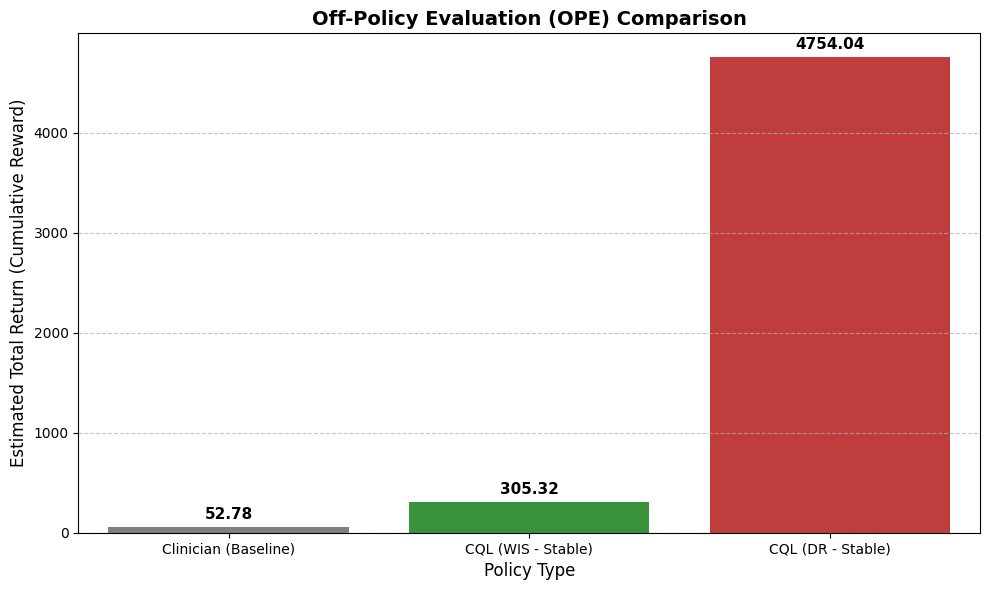

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
# "Clinician" is the standard term in medical RL papers (vs "Doctor")
metrics = ['Clinician (Baseline)', 'CQL (WIS - Stable)', 'CQL (DR - Stable)']
values = [52.7762, 305.3235, 4754.0401]
colors = ['#808080', '#2ca02c', '#d62728'] # Grey, Green, Red

# Create plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics, y=values, palette=colors)

# Annotate values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

plt.title('Off-Policy Evaluation (OPE) Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Estimated Total Return (Cumulative Reward)', fontsize=12)
plt.xlabel('Policy Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Since DR (Doubly Robust) is very high, we can use a logarithmic y-axis (Optional)
# plt.yscale('log') 

plt.tight_layout()
plt.savefig('ope_results_comparison.png', dpi=300)
plt.show()


# Step 14: SHAP Analysis: Action-Based Model Interpretability

This section explains the model's decision-making logic for a specific clinical intervention (e.g., **Vasopressor administration**). By utilizing **SHAP (SHapley Additive exPlanations)**, we can visualize which physiological features led the model to recommend a specific action for a given patient.

---

## 1. Dimensionality Synchronization
In Reinforcement Learning or Multi-class models, SHAP values are typically generated in a 3D array with the shape:  
**[Number of Samples, Number of Features, Number of Actions]**

* **Slicing:** We isolate the analysis to a single action (e.g., `ACTION_IDX = 2` for Vasopressors).
* **Alignment:** The code automatically aligns the feature names and the input data (`X_sample`) with the SHAP matrix to ensure that every data point on the plot corresponds to the correct clinical variable.

---

## 2. Interpreting the Visualizations

### **A. Beeswarm Summary Plot**
The beeswarm plot reveals the **distribution** and **direction** of feature impacts. It is essential for understanding the relationship between feature values and model predictions.



* **X-Axis (SHAP Value):** Represents the impact on the model's output. A positive SHAP value (right side) increases the probability of the action, while a negative value (left side) decreases it.
* **Color Scale:** Represents the actual value of the feature. **Red** indicates high values (e.g., high Lactate), and **Blue** indicates low values (e.g., low Blood Pressure).
* **Clinical Logic Check:** For a Vasopressor action, you might expect to see **low MAP (Blue)** on the **positive SHAP (Right)** side, confirming the model recommends action when blood pressure is low.

### **B. Global Feature Importance (Bar Chart)**
While the beeswarm plot shows individual variance, the bar chart summarizes the **global magnitude** of each feature's influence across the entire dataset.



* **Calculation:** It uses the **Mean Absolute SHAP value**—the average absolute impact across all patients.
* **Utility:** This identifies which clinical parameters are the "primary drivers" of the model’s strategy for this specific action, ranked from most to least influential.

---

### 3. Key Outputs
1.  **Publication-Ready Plots:** All figures are saved at **300 DPI** in `.png` format, suitable for inclusion in a thesis or academic paper.
2.  **Ranking Table:** A printed DataFrame providing the exact numerical values for `Mean_Abs_SHAP`, allowing for quantitative reporting of feature contributions.

---

--- Starting SHAP Analysis for Vasopressor (Action 2) ---
Number of Analyzed Samples: 200
Number of Analyzed Features: 11


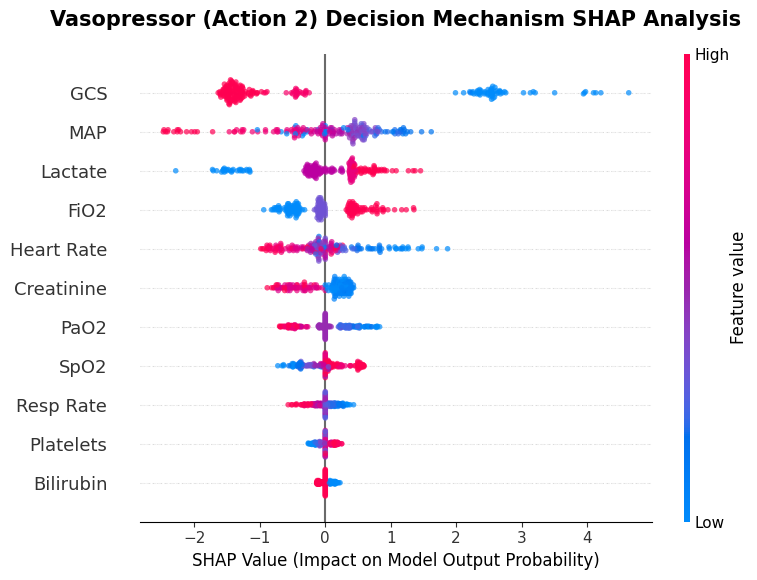


Feature Importance Ranking regarding the Decision:
       Feature  Mean_Abs_SHAP
10         GCS       1.686612
1          MAP       0.670142
4      Lactate       0.540062
9         FiO2       0.430991
0   Heart Rate       0.417672
6   Creatinine       0.320323
8         PaO2       0.312259
3         SpO2       0.252929
2    Resp Rate       0.139955
7    Platelets       0.099139
5    Bilirubin       0.078099

Feature Importance Ranking regarding the Decision:
       Feature  Mean_Abs_SHAP
10         GCS       1.686612
1          MAP       0.670142
4      Lactate       0.540062
9         FiO2       0.430991
0   Heart Rate       0.417672
6   Creatinine       0.320323
8         PaO2       0.312259
3         SpO2       0.252929
2    Resp Rate       0.139955
7    Platelets       0.099139
5    Bilirubin       0.078099


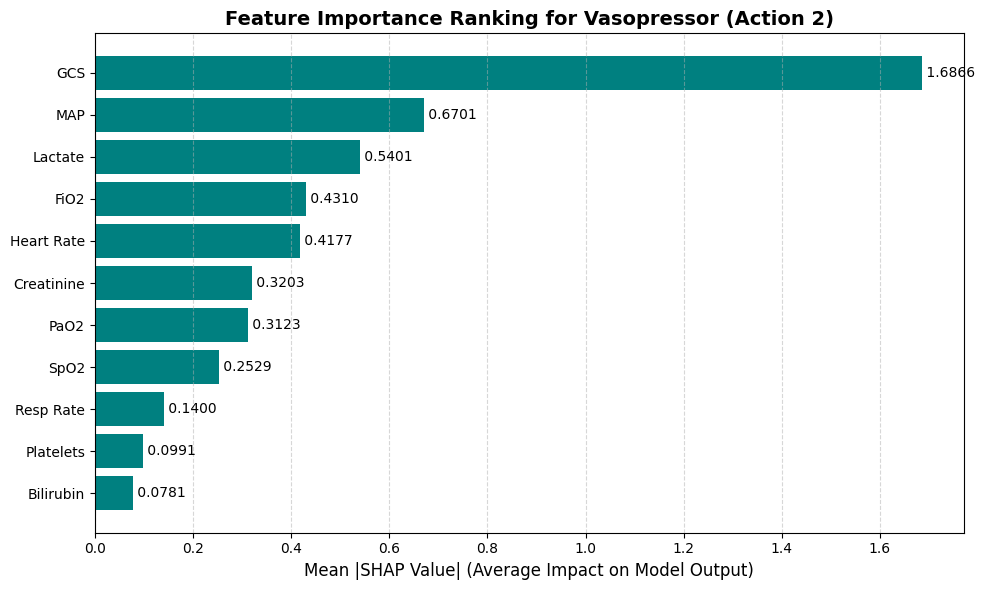

In [31]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# =========================================================
# SHAP ANALYSIS: ACTION-BASED VISUALIZATION (FULL CODE)
# =========================================================

# 1. PARAMETER SETTINGS
# Action Indices: 0:None, 1:Fluids, 2:Vaso, 3:Both
ACTION_IDX = 2  # The action you want to analyze (e.g., 2 = Vasopressor)
ACTION_NAME = "Vasopressor (Action 2)"

print(f"--- Starting SHAP Analysis for {ACTION_NAME} ---")

# 2. DIMENSION SYNCHRONIZATION (3D -> 2D)
# shap_values shape: (Num Samples, Num Features, Num Actions) -> e.g., (200, 11, 4)
# We slice it as [All Rows, All Cols, Selected Action].
selected_shap_values = shap_values[:, :, ACTION_IDX]

# 3. DATA AND NAME ALIGNMENT
n_rows, n_cols = selected_shap_values.shape

# Trim X_sample to match the SHAP matrix (Critical to avoid shape mismatch errors)
if isinstance(X_sample, pd.DataFrame):
    X_final = X_sample.iloc[:n_rows, :n_cols]
else:
    X_final = X_sample[:n_rows, :n_cols]

# Limit feature names based on the number of columns
# Assuming 'friendly_names' list was defined in a previous cell (e.g., Cell 14)
friendly_names_final = friendly_names[:n_cols]

print(f"Number of Analyzed Samples: {n_rows}")
print(f"Number of Analyzed Features: {n_cols}")

# 4. VISUALIZATION
plt.figure(figsize=(12, 8))

# Summary Plot (Beeswarm)
# Each dot represents a patient (sample).
# Red: High feature value, Blue: Low feature value.
shap.summary_plot(
    selected_shap_values, 
    X_final, 
    feature_names=friendly_names_final, 
    plot_type="dot", 
    show=False,
    alpha=0.7
)

# Aesthetics
plt.title(f"{ACTION_NAME} Decision Mechanism SHAP Analysis", fontsize=15, pad=20, fontweight='bold')
plt.xlabel("SHAP Value (Impact on Model Output Probability)", fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3) # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.2)

# Save File (For inclusion in Thesis/Paper)
plt.tight_layout()
plt.savefig(f'shap_analysis_action_{ACTION_IDX}.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. CLINICAL IMPORTANCE RANKING (Optional: Print as Table)
vals = np.abs(selected_shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(friendly_names_final, vals)),
                                  columns=['Feature', 'Mean_Abs_SHAP'])
feature_importance.sort_values(by=['Mean_Abs_SHAP'], ascending=False, inplace=True)

print("\nFeature Importance Ranking regarding the Decision:")
print(feature_importance)

# ... (Önceki kodlarınız yukarıda aynen kalacak)

print("\nFeature Importance Ranking regarding the Decision:")
print(feature_importance)

# =========================================================
# 6. FEATURE IMPORTANCE BAR CHART (YENİ EKLENEN KISIM)
# =========================================================
plt.figure(figsize=(10, 6))

# Renk paleti oluştur (En önemliler koyu, az önemliler açık renk)
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))

# Yatay Bar Grafiği Çizimi
plt.barh(feature_importance['Feature'], feature_importance['Mean_Abs_SHAP'], color='teal')

# Estetik Ayarlar
plt.xlabel("Mean |SHAP Value| (Average Impact on Model Output)", fontsize=12)
plt.title(f"Feature Importance Ranking for {ACTION_NAME}", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # En önemli özelliği en üste taşır
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Barların ucuna değerleri yazdırma (Opsiyonel ama şık durur)
for index, value in enumerate(feature_importance['Mean_Abs_SHAP']):
    plt.text(value, index, f' {value:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'feature_importance_bar_{ACTION_IDX}.png', dpi=300) # Kaydetme
plt.show()
